In [86]:
import requests

import matplotlib.pyplot as plt
import seaborn as sns

import umap, numpy as np, pandas as pd

from nltk import FreqDist

import pandas as pd

from sklearn.decomposition import TruncatedSVD
from scipy import sparse
import numpy as np

from collections import Counter
from scipy.sparse import csr_matrix

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score

In [87]:
import warnings
warnings.filterwarnings('ignore')

# Or for specific warning types:
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [88]:
labyrinthus_df = pd.read_parquet("../data/labyrinthus_df_classified.parquet")
# labyrinthus_df = labyrinthus_df[['author', 'title', 'grela_id', 'sentence_id', 'sentence_text',
#       'context_3sents', 'tokens', 'concordance_tokens', 'classification', 'not_before',
#       'not_after', 'date_random', 'lagt_genre', 'lagt_provenience',
#       'noscemus_genre', 'noscemus_discipline', 'target_token_id',
#       'target_char_start', 'target_char_end']]
labyrinthus_df.sample(5)


author  \
593                     Falloppio, Gabriele   
894                          Schott, Kaspar   
582                      Patrizi, Francesco   
267  Paracelsus, Theophrastus von Hohenheim   
18                 Hildebertus Cenomanensis   

                                                 title         grela_id  \
593  Gabrieli Fallopii Mutinensis medici Observatio...  noscemus_731574   
894  Magia universalis naturae et artis sive recond...  noscemus_928148   
582  Francisci Patricii Nova de universis philosoph...  noscemus_726758   
267                                               None     emlap_100023   
18                                     De S. Vincentio         cc_10920   

              sentence_id                                      sentence_text  \
593   noscemus_731574_466  Principium uero coecae cauitatis oritur a secu...   
894   noscemus_928148_492  Sunt in ea, ut supra dicebam, ductus meatusque...   
582  noscemus_726758_7517  rogabimus, an intellectio enim ex falsitatis l...   
267      emlap_100023_111  Que autem contra naturae lumen uel suscipiuntu...   
18            cc_10920_96  Uermis edax intus, meus hic alter labyrinthus ...   

                                        context_3sents  \
593  Quoniam meatus dicti ita parui ac exiles sunt,...   
894  ordine dispositis. | Sunt in ea, ut supra dice...   
582  Quis catur, hoc non sequi, quia sit semper in ...   
267  Considerare licebit omnes omnium scribentium l...   
18   Magus est qui talia uicit, Sed superanda mago ...   

                                                tokens  \
593  [{'char_end': 10, 'char_start': 0, 'lemma': 'p...   
894  [{'char_end': 4, 'char_start': 0, 'lemma': 'su...   
582  [{'char_end': 9, 'char_start': 0, 'lemma': 'ro...   
267  [{'char_end': 3, 'char_start': 0, 'lemma': 'qu...   
18   [{'char_end': 6, 'char_start': 0, 'lemma': 'ue...   

                                    concordance_tokens  not_before  not_after  \
593  [{'char_end': 90, 'char_start': 88, 'lemma': '...      1562.0     1562.0   
894  [{'char_end': 11, 'char_start': 10, 'lemma': '...      1657.0     1659.0   
582  [{'char_end': 62, 'char_start': 61, 'lemma': '...      1591.0     1591.0   
267  [{'char_end': 34, 'char_start': 31, 'lemma': '...      1553.0     1553.0   
18   [{'char_end': 152, 'char_start': 147, 'lemma':...      1056.0     1133.0   

     date_random lagt_genre lagt_provenience                noscemus_genre  \
593       1562.0       None             None                Report, Letter   
894       1658.0       None             None             Encyclopedic work   
582       1591.0       None             None  Monograph, Encyclopedic work   
267       1553.0       None             None                          None   
18        1064.0       None             None                          None   

                                   noscemus_discipline  target_token_id  \
593                                           Medicine          5268522   
894      Mathematics, Physics, Other (see description)        110498625   
582  Mathematics, Physics, Astronomy/Astrology/Cosm...         77450277   
267                                               None          2542151   
18                                                None        323677286   

     target_char_start  target_char_end  classification_single  \
593                145              156                      4   
894                 54               64                      4   
582                 45               55                      3   
267                 89              100                      3   
18                  34               45                      6   

    classification_single_label  
593          medical_anatomical  
894          medical_anatomical  
582               philosophical  
267               philosophical  
18                       poetic

In [89]:
len(labyrinthus_df)

916

In [90]:
labyrinthus_df["classification_single_label"].value_counts()

classification_single_label
medical_anatomical       194
mythological             183
metaphorical_general     180
geographical             103
philosophical             92
scientific_alchemical     71
poetic                    57
astronomical              18
spiritual_religious       14
historical_political       4
Name: count, dtype: int64

In [7]:
# ===============================================================
# 0. Imports & model
# ===============================================================
import torch, numpy as np, unicodedata
from collections import defaultdict
from transformers import AutoTokenizer, AutoModel

MODEL_ID = "xlm-roberta-base"
#DEVICE   = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE = "cpu"                     # single line change

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
model     = AutoModel.from_pretrained(
                MODEL_ID,
                output_hidden_states=True,
                output_attentions=True
            ).to(DEVICE).eval()



In [8]:
def augment_with_subwords(
        tokens: list[dict],
        *,
        tokenizer,
        anchor_use_lemma: bool,
        target_lemma: str
):
    """
    Adds subword token information to each token.

    Returns
    -------
    sent_str   : str
        Sentence string passed to model (space-separated).
    sp_tokens  : list[str]
        Full subword token sequence, including <s> and </s>.
    aug_tokens : list[dict]
        Original tokens extended with "sp_first" and "sp_pieces".
    """
    target_lemma = target_lemma.lower()

    aug_tokens, words, sp_tokens = [], [], ["<s>"]
    sp_pos = 1

    for t in tokens:
        is_anchor = t["lemma"].lower() == target_lemma
        word = (t["lemma"].lower() if (is_anchor and anchor_use_lemma)
                else t["token_text"].lower())

        pieces = tokenizer.convert_ids_to_tokens(
            tokenizer(word, add_special_tokens=False)["input_ids"]
        )

        new_t = dict(t)
        new_t["sp_first"]  = sp_pos
        new_t["sp_pieces"] = pieces
        aug_tokens.append(new_t)

        words.append(word)
        sp_tokens.extend(pieces)
        sp_pos += len(pieces)

    sp_tokens.append("</s>")
    sent_str = " ".join(words)

    return sent_str, sp_tokens, aug_tokens
# --------------------------------------------------------------
# helper: always encode with safe truncation
# --------------------------------------------------------------
MAX_LEN = tokenizer.model_max_length        # 512 for xlm-roberta-base

def encode_trunc(text: str):
    return tokenizer(
        text,
        return_tensors="pt",
        add_special_tokens=True,
        truncation=True,
        max_length=MAX_LEN,
    ).to(DEVICE)          # use *the same* `device` you pass in


# --------------------------------------------------------------
# 1) hidden-state embedding  (layer_idx, mean/sum unchanged)
# --------------------------------------------------------------
def hidden_anchor_embedding(
        aug_tokens: list[dict],
        sent_str: str,
        *,
        tokenizer,
        model,
        device,
        target_lemma: str,
        layer_idx: int = 8,
        piece_pooling: str = "mean",
):
    target_lemma = target_lemma.lower()
    anchor = next(t for t in aug_tokens if t["lemma"].lower() == target_lemma)

    sp_first = anchor["sp_first"]
    k        = len(anchor["sp_pieces"])

    enc = encode_trunc(sent_str)

    # anchor disappeared after truncation? → return zeros
    if sp_first + k - 1 >= enc["input_ids"].shape[-1]:
        return np.zeros(model.config.hidden_size, dtype=np.float32)

    with torch.no_grad():
        hidden = model(**enc).hidden_states[layer_idx].squeeze(0)  # [L,768]

    span = hidden[sp_first : sp_first + k]
    vec  = span.sum(dim=0) if piece_pooling == "sum" else span.mean(dim=0)
    return vec.cpu().numpy()


# --------------------------------------------------------------
# 2) attention map  (any layer, sub-piece sum kept)
# --------------------------------------------------------------
from collections import defaultdict

def attention_weights_by_lemma(
        aug_tokens: list[dict],
        sent_str: str,
        *,
        tokenizer,
        model,
        device,
        att_layer: int,
        target_lemma: str,
):
    target_lemma = target_lemma.lower()
    enc = encode_trunc(sent_str)

    with torch.no_grad():
        outs = model(**enc)

    A = outs.attentions[att_layer][0].mean(dim=0).cpu()  # [L,L]

    anchor = next(t for t in aug_tokens if t["lemma"].lower() == target_lemma)
    sp_first = anchor["sp_first"]
    k_anchor = len(anchor["sp_pieces"])

    # anchor lost after truncation? → empty dict
    if sp_first + k_anchor - 1 >= A.shape[-1]:
        return {}

    anchor_vec = A[sp_first : sp_first + k_anchor].mean(dim=0)     # [L]

    lemma_info = defaultdict(lambda: {"weight": 0.0, "pieces": []})

    for t in aug_tokens:
        lemma = t["lemma"].lower()
        if lemma == target_lemma:
            continue

        start = t["sp_first"]
        end   = start + len(t["sp_pieces"])

        if end > A.shape[-1]:               # this token was truncated away
            continue

        total_w = anchor_vec[start:end].sum().item()
        lemma_info[lemma]["weight"] += total_w

        for j, piece in enumerate(t["sp_pieces"]):
            idx = start + j
            lemma_info[lemma]["pieces"].append({
                "piece":  piece,
                "sp_idx": idx,
                "weight": float(anchor_vec[idx]),
            })

    return dict(lemma_info)

In [9]:
# ------------------------------------------------------------
# 0.  Pick one GreLa row  (already loaded in your notebook)
# ------------------------------------------------------------
row = labyrinthus_df.iloc[5]          # ← any row you like
tokens = row["tokens"]                # list[dict] from GreLa schema

# ------------------------------------------------------------
# 1.  Sub-word augmentation  (anchor in LEMMA form here)
# ------------------------------------------------------------
sent_str, sp_tokens, aug_tokens = augment_with_subwords(
    tokens,
    tokenizer      = tokenizer,
    anchor_use_lemma = True,          # anchor lemma, context surface
    target_lemma     = "labyrinthus"  # must be lower-case
)

print("Sentence fed to XLM-R:")
print(sent_str)
print()

# ------------------------------------------------------------
# 2.  Hidden-state embedding of the anchor  (layer 8, mean pooling)
# ------------------------------------------------------------
embed_vec = hidden_anchor_embedding(
    aug_tokens   = aug_tokens,
    sent_str     = sent_str,
    tokenizer    = tokenizer,
    model        = model,
    device       = DEVICE,
    target_lemma = "labyrinthus",
    layer_idx    = 8,          # try 7–9 for semantics, 11–12 for syntax
    piece_pooling = "mean"     # or "sum"
)

print("Anchor embedding   shape:", embed_vec.shape)      # (768,)
print("First 5 dims:", embed_vec[:5])
print()

# ------------------------------------------------------------
# 3.  Attention weights from anchor → other lemmas  (layer 8)
# ------------------------------------------------------------
att_dict = attention_weights_by_lemma(
    aug_tokens   = aug_tokens,
    sent_str     = sent_str,
    tokenizer    = tokenizer,
    model        = model,
    device       = DEVICE,
    att_layer    = 11,            # any 0-11
    target_lemma = "labyrinthus"
)

# Pretty-print the top 8 strongest lemma links
for lem, info in sorted(att_dict.items(),
                        key=lambda kv: kv[1]["weight"],
                        reverse=True)[:8]:
    print(f"{lem:<12}  total_w={info['weight']:.4f}  "
          f"sub-pieces={len(info['pieces'])}")    # (768,)

XLMRobertaSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Sentence fed to XLM-R:
quanto satius liberas quibusque electiones juxta canonum scita relinquens , teipsum tot malorum labyrinthus explicares , et tuas ad hoc tantum partes interponeres ut , qui deo acceptum , et in his quae dei sunt , populo tibi credito et subdito profuturum eligerent , praeualerent , et in contrarium nitentes in suis molitionibus elisi deficerent ?

Anchor embedding   shape: (768,)
First 5 dims: [-0.15841481 -0.06213838  0.3145943   0.33562058 -0.02968704]

malus         total_w=0.0092  sub-pieces=2
in            total_w=0.0090  sub-pieces=3
praeualeo     total_w=0.0078  sub-pieces=4
contrarius    total_w=0.0075  sub-pieces=2
,             total_w=0.0074  sub-pieces=14
qui           total_w=0.0069  sub-pieces=2
et            total_w=0.0059  sub-pieces=4
teipsus       total_w=0.0051  sub-pieces=3


In [13]:
def _xlmr_cols(tokens, tokenizer, target_lemma="labyrinthus", anchor_use_lemma=True):
    """
    Flexible function to generate XLM-R columns for any token input.

    Parameters:
    -----------
    tokens : list[dict]
        Token list (e.g., row["tokens"] or row["concordance_tokens"])
    tokenizer : tokenizer object
        The XLM-R tokenizer
    target_lemma : str
        Target lemma to process
    anchor_use_lemma : bool
        Whether to use lemma form for anchor

    Returns:
    --------
    pd.Series with xlmr_sentence, xlmr_sp_tokens, xlmr_aug_tokens
    """
    sent_str, sp_tokens, aug_tokens = augment_with_subwords(
        tokens,
        tokenizer=tokenizer,
        anchor_use_lemma=anchor_use_lemma,
        target_lemma=target_lemma
    )
    return pd.Series({
        "xlmr_sentence": sent_str,
        "xlmr_sp_tokens": sp_tokens,
        "xlmr_aug_tokens": aug_tokens
    })

# Generate columns for regular tokens
labyrinthus_df[["xlmr_sentence", "xlmr_sp_tokens", "xlmr_aug_tokens"]] = (
    labyrinthus_df["tokens"].apply(
        lambda tokens: _xlmr_cols(tokens, tokenizer)
    )
)

# Generate columns for concordance tokens
labyrinthus_df[["xlmr_conc_text", "xlmr_conc_sp_tokens", "xlmr_conc_aug_tokens"]] = (
    labyrinthus_df["concordance_tokens"].apply(
        lambda tokens: _xlmr_cols(tokens, tokenizer)
    )
)


In [15]:
labyrinthus_df.iloc[0]["xlmr_conc_aug_tokens"]

[{'char_end': 303,
  'char_start': 299,
  'lemma': 'bonum',
  'pos': 'ADJ',
  'sentence_id': 'cc_10012_2811',
  'token_id': 334984548,
  'token_text': 'bona',
  'sp_first': 1,
  'sp_pieces': ['▁bona']},
 {'char_end': 304,
  'char_start': 303,
  'lemma': '.',
  'pos': 'PUNCT',
  'sentence_id': 'cc_10012_2811',
  'token_id': 334984549,
  'token_text': '.',
  'sp_first': 2,
  'sp_pieces': ['▁', '.']},
 {'char_end': 8,
  'char_start': 0,
  'lemma': 'exploro',
  'pos': 'VERB',
  'sentence_id': 'cc_10012_2812',
  'token_id': 334984550,
  'token_text': 'Exploret',
  'sp_first': 4,
  'sp_pieces': ['▁explore', 't']},
 {'char_end': 12,
  'char_start': 9,
  'lemma': 'qui',
  'pos': 'PRON',
  'sentence_id': 'cc_10012_2812',
  'token_id': 334984551,
  'token_text': 'qui',
  'sp_first': 6,
  'sp_pieces': ['▁qui']},
 {'char_end': 19,
  'char_start': 13,
  'lemma': 'possum',
  'pos': 'VERB',
  'sentence_id': 'cc_10012_2812',
  'token_id': 334984552,
  'token_text': 'potest',
  'sp_first': 7,
  'sp_pie

In [16]:
def _layer_feats(row, layer, token_type="regular"):
    """
    Extract layer features for different token types.

    Parameters:
    -----------
    row : pd.Series
        DataFrame row containing the token data
    layer : int
        Layer number to extract features from
    token_type : str
        Either "regular" or "concordance" to specify which tokens to use

    Returns:
    --------
    pd.Series with embedding and attention features
    """
    if token_type == "regular":
        aug_tokens_col = "xlmr_aug_tokens"
        sent_str_col = "xlmr_sentence"
        embed_col = f"embed_l{layer}"
        att_col = f"att_l{layer}"
    elif token_type == "concordance":
        aug_tokens_col = "xlmr_conc_aug_tokens"
        sent_str_col = "xlmr_conc_text"
        embed_col = f"embed_conc_l{layer}"
        att_col = f"att_conc_l{layer}"
    else:
        raise ValueError("token_type must be 'regular' or 'concordance'")

    emb = hidden_anchor_embedding(
        aug_tokens   = row[aug_tokens_col],
        sent_str     = row[sent_str_col],
        tokenizer    = tokenizer,
        model        = model,
        device       = DEVICE,
        target_lemma = "labyrinthus",
        layer_idx    = layer,
        piece_pooling= "mean",
    )
    att = attention_weights_by_lemma(
        aug_tokens   = row[aug_tokens_col],
        sent_str     = row[sent_str_col],
        tokenizer    = tokenizer,
        model        = model,
        device       = DEVICE,
        target_lemma = "labyrinthus",
        att_layer    = layer,
    )
    return pd.Series({embed_col: emb, att_col: att})

# Generate features for regular tokens
for L in range(5, 12):           # layers 5-11
    labyrinthus_df[[f"embed_l{L}", f"att_l{L}"]] = (
        labyrinthus_df.apply(_layer_feats, layer=L, token_type="regular", axis=1)
    )

# Generate features for concordance tokens
for L in range(5, 12):           # layers 5-11
    labyrinthus_df[[f"embed_conc_l{L}", f"att_conc_l{L}"]] = (
        labyrinthus_df.apply(_layer_feats, layer=L, token_type="concordance", axis=1)
    )

In [17]:
labyrinthus_df.columns

Index(['author', 'title', 'grela_id', 'sentence_id', 'sentence_text',
       'context_3sents', 'tokens', 'concordance_tokens', 'not_before',
       'not_after', 'date_random', 'lagt_genre', 'lagt_provenience',
       'noscemus_genre', 'noscemus_discipline', 'target_token_id',
       'target_char_start', 'target_char_end', 'classification_single',
       'classification_single_label', 'xlmr_sentence', 'xlmr_sp_tokens',
       'xlmr_aug_tokens', 'embed_l5', 'att_l5', 'embed_l6', 'att_l6',
       'embed_l7', 'att_l7', 'embed_l8', 'att_l8', 'embed_l9', 'att_l9',
       'embed_l10', 'att_l10', 'embed_l11', 'att_l11', 'xlmr_conc_text',
       'xlmr_conc_sp_tokens', 'xlmr_conc_aug_tokens', 'embed_conc_l5',
       'att_conc_l5', 'embed_conc_l6', 'att_conc_l6', 'embed_conc_l7',
       'att_conc_l7', 'embed_conc_l8', 'att_conc_l8', 'embed_conc_l9',
       'att_conc_l9', 'embed_conc_l10', 'att_conc_l10', 'embed_conc_l11',
       'att_conc_l11'],
      dtype='object')

## Build term-doc co-occurrence matrix

In [22]:
labyrinthus_df.head(5)

author                                 title  \
0  Humbertus Silvae Candidae1010-1061                    Adversus Simoniacos   
1                      Petrus Damianus           Patrologia Latina, vol. 145   
2               Rodulphus S. Trudonis                      Vita S. Lietberti   
3                    Domnizo Canusinus             Vita et carmina Mathildis   
4               Durandus Trobarnensis   Liber de corpore et sanguine Christi   

   grela_id    sentence_id                                      sentence_text  \
0  cc_10012  cc_10012_2812  Exploret qui potest qualiter, et qua hunc laby...   
1  cc_10077    cc_10077_50  Et poenae factus est auctor, qui poenalis laby...   
2  cc_10161    cc_10161_32  mirantibus magistris penetrat labyrinthos Scri...   
3  cc_10261   cc_10261_892  Ista fuit, quae par habuit regemque Deumque, H...   
4  cc_10298   cc_10298_920  Uerum quia quidam peruersi ex hac tanti doctor...   

                                      context_3sents  \
0  Si enim, ut philosophus allegat, qui non prohi...   
1  Protinus igitur projectus in taurum, quod infe...   
2  Ducitur sitibundo pectore currens ad fontem ph...   
3  Ista fuit, quae diripuit Paulumque Petrumque; ...   
4  Xxui. | Uerum quia quidam peruersi ex hac tant...   

                                              tokens  \
0  [{'char_end': 8, 'char_start': 0, 'lemma': 'ex...   
1  [{'char_end': 2, 'char_start': 0, 'lemma': 'et...   
2  [{'char_end': 10, 'char_start': 0, 'lemma': 'm...   
3  [{'char_end': 4, 'char_start': 0, 'lemma': 'is...   
4  [{'char_end': 5, 'char_start': 0, 'lemma': 'ue...   

                                  concordance_tokens  not_before  not_after  \
0  [{'char_end': 303, 'char_start': 299, 'lemma':...      1010.0     1061.0   
1  [{'char_end': 83, 'char_start': 75, 'lemma': '...      1007.0     1072.0   
2  [{'char_end': 144, 'char_start': 136, 'lemma':...         NaN        NaN   
3  [{'char_end': 43, 'char_start': 40, 'lemma': '...      1130.0     1130.0   
4  [{'char_end': 10, 'char_start': 6, 'lemma': 'q...         NaN        NaN   

   ...                                      embed_conc_l7  \
0  ...  [-0.4876147, 0.10675663, 0.31626156, -0.015214...   
1  ...  [-0.5875766, 0.41169846, 0.32633185, -0.030615...   
2  ...  [-0.07679878, 0.28734928, 0.16146778, -0.27141...   
3  ...  [-0.23514198, 0.116306506, 0.29702535, 0.02996...   
4  ...  [-0.5390179, 0.16021687, 0.24410799, -0.090121...   

                                         att_conc_l7  \
0  {'bonum': {'weight': 0.003490303410217166, 'pi...   
1  {'probo': {'weight': 0.0033923382870852947, 'p...   
2  {'physicus': {'weight': 0.005687706638127565, ...   
3  {'que': {'weight': 0.0021174177527427673, 'pie...   
4  {'quia': {'weight': 0.005565307103097439, 'pie...   

                                       embed_conc_l8  \
0  [-0.6485373, -0.0055015963, 0.20263168, 0.2193...   
1  [-0.64597905, 0.09320098, 0.19760107, 0.470872...   
2  [0.020625375, 0.11646694, 0.056183375, 0.19960...   
3  [-0.15099189, 0.07395666, 0.08478473, 0.337988...   
4  [-0.60231787, -0.09290295, 0.24135038, 0.27981...   

                                         att_conc_l8  \
0  {'bonum': {'weight': 0.0024725699331611395, 'p...   
1  {'probo': {'weight': 0.0027367393486201763, 'p...   
2  {'physicus': {'weight': 0.0021060507278889418,...   
3  {'que': {'weight': 0.00419851066544652, 'piece...   
4  {'quia': {'weight': 0.014718449674546719, 'pie...   

                                       embed_conc_l9  \
0  [-0.4795255, -0.07217107, 0.08098863, 0.014220...   
1  [-0.55308026, -0.1844841, 0.14687206, 0.390055...   
2  [-0.10799371, 0.014479745, 0.074815676, 0.0484...   
3  [-0.19174851, 0.027542405, 0.07310989, 0.38478...   
4  [-0.5003311, -0.25676066, 0.15292183, 0.064456...   

                                         att_conc_l9  \
0  {'bonum': {'weight': 0.006108064204454422, 'pi...   
1  {'probo': {'weight': 0.005723948590457439, 'pi...   
2  {'physicus': {'weight': 0.006

In [23]:
import re, pandas as pd
from collections import Counter

# ------------------------- configurable filters --------------------------
OPEN_POS  = {"NOUN", "PROPN", "ADJ", "VERB"}      # keep these POS tags
LEMMA_RE  = re.compile(r"^[a-zæœāēīōū]+$", re.I)  # valid-lemma pattern
MIN_DF    = 2      # keep lemmas that occur in at least MIN_DF documents
BINARY    = False  # True → 1/0 (presence); False → term-frequency counts
# -------------------------------------------------------------------------

def lemma_ok(lemma: str) -> bool:
    """Regex filter for lemmas (drop pure punctuation etc.)."""
    return bool(LEMMA_RE.fullmatch(lemma))

def build_doc_term_df(token_lists, doc_ids):
    """
    Parameters
    ----------
    token_lists : list[list[dict]]
        Each inner list is the GreLa tokens for one document / sentence.
    doc_ids : list[str]
        One identifier per document (must align with token_lists).

    Returns
    -------
    pandas.DataFrame
        index = doc_ids, columns = lemmas, values = freq or 0/1
    """
    assert len(token_lists) == len(doc_ids)

    # 1️⃣  Collect per-document lemma counts
    per_doc_counts = []
    global_df      = Counter()      # document-frequency per lemma

    for toks in token_lists:
        lemmas = [
            t["lemma"].lower()
            for t in toks
            if t["pos"] in OPEN_POS and lemma_ok(t["lemma"])
        ]
        counts = Counter(lemmas)
        per_doc_counts.append(counts)

        # update DF once per lemma per doc
        global_df.update(set(counts))

    # 2️⃣  Decide which lemmas to keep (min_df)
    kept_lemmas = {lemma for lemma, df in global_df.items() if df >= MIN_DF}
    kept_lemmas = sorted(kept_lemmas)          # deterministic column order

    # 3️⃣  Build a DataFrame
    data = []
    for counts in per_doc_counts:
        if BINARY:
            row = [int(lemma in counts) for lemma in kept_lemmas]
        else:
            row = [counts.get(lemma, 0) for lemma in kept_lemmas]
        data.append(row)

    return pd.DataFrame(data, index=doc_ids, columns=kept_lemmas)

# ------------------------- example usage ---------------------------------

# Each row["tokens"] is your GreLa token list for a sentence
doc_ids     = labyrinthus_df["sentence_id"].tolist()
token_lists = labyrinthus_df["tokens"].tolist()

doc_term_df = build_doc_term_df(token_lists, doc_ids)

# Repeat with concordance data as input

token_lists = labyrinthus_df["concordance_tokens"].tolist()

conc_doc_term_df = build_doc_term_df(token_lists, doc_ids)


print(doc_term_df.shape)
doc_term_df.head()

(916, 1756)


abdo  abduco  abeo  abscondo  absoluo  absolutissimus  \
cc_10012_2812     0       0     0         0        0               0   
cc_10077_50       0       0     0         0        0               0   
cc_10161_32       0       0     0         0        0               0   
cc_10261_892      0       0     0         0        0               0   
cc_10298_920      0       0     0         0        0               0   

               abstrudo  absum  absurdus  accedo  ...  usitatus  usurpo  usus  \
cc_10012_2812         0      0         0       0  ...         0       0     0   
cc_10077_50           0      0         0       0  ...         0       0     0   
cc_10161_32           0      0         0       0  ...         0       0     0   
cc_10261_892          0      0         0       0  ...         0       0     0   
cc_10298_920          0      0         0       0  ...         0       0     0   

               utilitas  utor  uulgaris  uxor  witteberga  x  zona  
cc_10012_2812         0     0         0     0           0  0     0  
cc_10077_50           0     0         0     0           0  0     0  
cc_10161_32           0     0         0     0           0  0     0  
cc_10261_892          0     0         0     0           0  0     0  
cc_10298_920          0     0         0     0           0  0     0  

[5 rows x 1756 columns]

In [25]:
conc_doc_term_df.head(5)

abdo  abduco  abeo  absoluo  absurdus  accedo  accesso  \
cc_10012_2812     0       0     0        0         0       0        0   
cc_10077_50       0       0     0        0         0       0        0   
cc_10161_32       0       0     0        0         0       0        0   
cc_10261_892      0       0     0        0         0       0        0   
cc_10298_920      0       0     0        0         0       0        0   

               accipio  accuso  acousticus  ...  uoluo  uoluptas  uorago  uox  \
cc_10012_2812        0       0           0  ...      0         0       0    0   
cc_10077_50          0       0           0  ...      0         0       0    0   
cc_10161_32          0       0           0  ...      0         0       0    0   
cc_10261_892         0       0           0  ...      0         0       0    0   
cc_10298_920         0       0           0  ...      0         0       0    0   

               urbs  usus  uterus  utilitas  utor  witteberga  
cc_10012_2812     0     0       0         0     0           0  
cc_10077_50       0     0       0         0     0           0  
cc_10161_32       0     0       0         0     0           0  
cc_10261_892      0     0       0         0     0           0  
cc_10298_920      0     0       0         0     0           0  

[5 rows x 1259 columns]

## Build attention embeddings from attention weights

In [28]:

def _att_to_vec(att_dict: dict[str, dict]) -> np.ndarray:
    """
    Convert one row’s attention–weight dictionary into
    a dense 1-D vector aligned with `vocabulary`.
    """
    vec = np.zeros(V, dtype=np.float32)
    for lemma, info in att_dict.items():
        i = lemma2idx.get(lemma)
        if i is not None:
            vec[i] = info["weight"]          # keep original (already summed)
    return vec

# --------------------------------------------------
# 1.  Build raw attention-row vectors for layers 8-11

# --------------------------------------------------
#  Fixed vocabulary and fast lookup
# --------------------------------------------------
vocabulary      = doc_term_df.columns.tolist()          # the global vocab
lemma2idx       = {lem: i for i, lem in enumerate(vocabulary)}
V               = len(vocabulary)

# --------------------------------------------------
for L in range(5, 12):
    col_att   = f"att_l{L}"          # dict column
    col_embed = f"att_l{L}_raw_embed"

    labyrinthus_df[col_embed] = (
        labyrinthus_df[col_att]
        .apply(_att_to_vec)          # → np.ndarray length |V|
    )#%%

# --------------------------------------------------
# 2.  Build raw attention-row vectors for concordance data from layers 8-11

# --------------------------------------------------
# 0.  Fixed vocabulary and fast lookup
# --------------------------------------------------

In [29]:
vocabulary      = conc_doc_term_df.columns.tolist()          # the global vocab
lemma2idx       = {lem: i for i, lem in enumerate(vocabulary)}
V               = len(vocabulary)

# --------------------------------------------------
for L in range(5, 12):
    col_att   = f"att_conc_l{L}"          # dict column
    col_embed = f"att_conc_l{L}_raw_embed"

    labyrinthus_df[col_embed] = (
        labyrinthus_df[col_att]
        .apply(_att_to_vec)          # → np.ndarray length |V|
    )#%%

In [33]:
labyrinthus_df.columns

Index(['author', 'title', 'grela_id', 'sentence_id', 'sentence_text',
       'context_3sents', 'tokens', 'concordance_tokens', 'not_before',
       'not_after', 'date_random', 'lagt_genre', 'lagt_provenience',
       'noscemus_genre', 'noscemus_discipline', 'target_token_id',
       'target_char_start', 'target_char_end', 'classification_single',
       'classification_single_label', 'xlmr_sentence', 'xlmr_sp_tokens',
       'xlmr_aug_tokens', 'embed_l5', 'att_l5', 'embed_l6', 'att_l6',
       'embed_l7', 'att_l7', 'embed_l8', 'att_l8', 'embed_l9', 'att_l9',
       'embed_l10', 'att_l10', 'embed_l11', 'att_l11', 'xlmr_conc_text',
       'xlmr_conc_sp_tokens', 'xlmr_conc_aug_tokens', 'embed_conc_l5',
       'att_conc_l5', 'embed_conc_l6', 'att_conc_l6', 'embed_conc_l7',
       'att_conc_l7', 'embed_conc_l8', 'att_conc_l8', 'embed_conc_l9',
       'att_conc_l9', 'embed_conc_l10', 'att_conc_l10', 'embed_conc_l11',
       'att_conc_l11', 'att_l5_raw_embed', 'att_l6_raw_embed',
       'att_

In [77]:
# ------------------------------------------------------------------
# helper: stack → fit SVD → project
# ------------------------------------------------------------------
def svd_project_attention(df, raw_col, layer: int, k: int = 400,
                          random_state: int = 42) -> np.ndarray:
    """
    Parameters
    ----------
    df     : the DataFrame that already contains `att_l{layer}_raw_embed`
    layer  : which attention layer (int)
    k      : number of SVD dimensions
    Returns
    -------
    np.ndarray shape (N, k) – projected vectors
    """
    X = np.stack(df[raw_col].values)          # (N, |V|)

    svd = TruncatedSVD(n_components=k, random_state=random_state)
    X_reduced = svd.fit_transform(X)

    total_var = svd.explained_variance_ratio_.sum()
    print(f"[layer {layer}] SVD-{k} covers {total_var:.4%} variance")

    return X_reduced          # (N, k)

# ------------------------------------------------------------------
# run for layers 8-11 and push back into the DF
# ------------------------------------------------------------------
for L in range(5, 12):
    svd_emb = svd_project_attention(labyrinthus_df, "att_l{}_raw_embed".format(L), layer=L, k=400)
    labyrinthus_df[f"att_l{L}_svd400_embed"] = list(svd_emb)

for L in range(5, 12):
    svd_emb = svd_project_attention(labyrinthus_df, "att_conc_l{}_raw_embed".format(L), layer=L, k=400)
    labyrinthus_df[f"att_conc_l{L}_svd400_embed"] = list(svd_emb)

[layer 5] SVD-400 covers 95.5246% variance
[layer 6] SVD-400 covers 95.4529% variance
[layer 7] SVD-400 covers 96.4967% variance
[layer 8] SVD-400 covers 96.5388% variance
[layer 9] SVD-400 covers 95.6240% variance
[layer 10] SVD-400 covers 94.9520% variance
[layer 11] SVD-400 covers 95.3415% variance
[layer 5] SVD-400 covers 95.3464% variance
[layer 6] SVD-400 covers 95.4601% variance
[layer 7] SVD-400 covers 96.6740% variance
[layer 8] SVD-400 covers 96.7745% variance
[layer 9] SVD-400 covers 95.6731% variance
[layer 10] SVD-400 covers 95.1801% variance
[layer 11] SVD-400 covers 95.1543% variance


In [78]:
labyrinthus_df.columns

Index(['author', 'title', 'grela_id', 'sentence_id', 'sentence_text',
       'context_3sents', 'tokens', 'concordance_tokens', 'not_before',
       'not_after', 'date_random', 'lagt_genre', 'lagt_provenience',
       'noscemus_genre', 'noscemus_discipline', 'target_token_id',
       'target_char_start', 'target_char_end', 'classification_single',
       'classification_single_label', 'xlmr_sentence', 'xlmr_sp_tokens',
       'xlmr_aug_tokens', 'embed_l5', 'att_l5', 'embed_l6', 'att_l6',
       'embed_l7', 'att_l7', 'embed_l8', 'att_l8', 'embed_l9', 'att_l9',
       'embed_l10', 'att_l10', 'embed_l11', 'att_l11', 'xlmr_conc_text',
       'xlmr_conc_sp_tokens', 'xlmr_conc_aug_tokens', 'embed_conc_l5',
       'att_conc_l5', 'embed_conc_l6', 'att_conc_l6', 'embed_conc_l7',
       'att_conc_l7', 'embed_conc_l8', 'att_conc_l8', 'embed_conc_l9',
       'att_conc_l9', 'embed_conc_l10', 'att_conc_l10', 'embed_conc_l11',
       'att_conc_l11', 'att_l5_raw_embed', 'att_l6_raw_embed',
       'att_

In [39]:
# ------------------------------------------------------------
# 0 .  Build / reuse the doc-term matrix  (⬅ already executed)
# ------------------------------------------------------------
# token_lists = labyrinthus_df["tokens"].tolist()
# doc_ids     = labyrinthus_df["sentence_id"].tolist()
# doc_term_df = build_doc_term_df(token_lists, doc_ids)

# ------------------------------------------------------------
# 1 .  Sparse SVD → 300-d document vectors
# ------------------------------------------------------------

# convert the dense DataFrame to  CSR once (saves RAM)
X_sparse = sparse.csr_matrix(doc_term_df.values, dtype=np.float32)

svd = TruncatedSVD(
    n_components = 400,
    algorithm    = "randomized",
    random_state = 42
)
doc_vecs = svd.fit_transform(X_sparse)          # shape = (n_docs, 300)

# ------------------------------------------------------------
# 2 .  Attach to the original DataFrame
#     (index alignment via sentence_id)
# ------------------------------------------------------------
# make sure both indexes line up; align if needed
assert (doc_term_df.index == labyrinthus_df["sentence_id"]).all(), \
       "sentence_id order mismatch!"

In [40]:
svd.explained_variance_ratio_.sum()

0.92344487

In [41]:
labyrinthus_df["svd400"] = list(doc_vecs)

In [21]:
labyrinthus_df["svd400"]

0      [1.0248758, -0.10942612, 0.18502046, -0.129020...
1      [0.9693511, -0.052010484, 0.1326823, -0.082074...
2      [0.98060316, -0.11566342, -0.02680232, -0.1812...
3      [1.1011388, 0.75830466, -0.08243356, -0.223232...
4      [1.1190267, -0.04811314, 0.15537265, -0.200599...
                             ...                        
911    [0.9160344, -0.11316829, -0.040722173, -0.1794...
912    [0.9160344, -0.11316829, -0.040722173, -0.1794...
913    [0.94951457, -0.11734156, -0.03615193, -0.1739...
914    [1.0508823, -0.021737091, -0.041115742, -0.107...
915    [1.0429592, -0.09953701, 0.19429348, -0.127935...
Name: svd400, Length: 916, dtype: object

In [22]:
labyrinthus_df.head(5)

author                                 title  \
0  Humbertus Silvae Candidae1010-1061                    Adversus Simoniacos   
1                      Petrus Damianus           Patrologia Latina, vol. 145   
2               Rodulphus S. Trudonis                      Vita S. Lietberti   
3                    Domnizo Canusinus             Vita et carmina Mathildis   
4               Durandus Trobarnensis   Liber de corpore et sanguine Christi   

   grela_id    sentence_id                                      sentence_text  \
0  cc_10012  cc_10012_2812  Exploret qui potest qualiter, et qua hunc laby...   
1  cc_10077    cc_10077_50  Et poenae factus est auctor, qui poenalis laby...   
2  cc_10161    cc_10161_32  mirantibus magistris penetrat labyrinthos Scri...   
3  cc_10261   cc_10261_892  Ista fuit, quae par habuit regemque Deumque, H...   
4  cc_10298   cc_10298_920  Uerum quia quidam peruersi ex hac tanti doctor...   

                                      context_3sents  \
0  Si enim, ut philosophus allegat, qui non prohi...   
1  Protinus igitur projectus in taurum, quod infe...   
2  Ducitur sitibundo pectore currens ad fontem ph...   
3  Ista fuit, quae diripuit Paulumque Petrumque; ...   
4  Xxui. | Uerum quia quidam peruersi ex hac tant...   

                                              tokens  \
0  [{'char_end': 8, 'char_start': 0, 'lemma': 'ex...   
1  [{'char_end': 2, 'char_start': 0, 'lemma': 'et...   
2  [{'char_end': 10, 'char_start': 0, 'lemma': 'm...   
3  [{'char_end': 4, 'char_start': 0, 'lemma': 'is...   
4  [{'char_end': 5, 'char_start': 0, 'lemma': 'ue...   

                                  concordance_tokens  \
0  [{'char_end': 303, 'char_start': 299, 'lemma':...   
1  [{'char_end': 83, 'char_start': 75, 'lemma': '...   
2  [{'char_end': 144, 'char_start': 136, 'lemma':...   
3  [{'char_end': 43, 'char_start': 40, 'lemma': '...   
4  [{'char_end': 10, 'char_start': 6, 'lemma': 'q...   

                classification  not_before  ...  \
0  metaphorical, philosophical      1010.0  ...   
1         metaphorical, poetic      1007.0  ...   
2      philosophical, metaphor         NaN  ...   
3  metaphorical, philosophical      1130.0  ...   
4                 metaphorical         NaN  ...   

                                    att_l6_raw_embed  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                    att_l7_raw_embed  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                 att_l5_svd400_embed  \
0  [0.0004623559, -0.00010708526, 0.00013034388, ...   
1  [0.00010564571, -1.860459e-05, 7.287792e-05, -...   
2  [0.0019628706, 0.0019864459, 0.002416587, 0.00...   
3  [0.00046321482, -3.694225e-05, 9.3953815e-05, ...   
4  [0.040973246, 0.08143698, -0.0011590486, -0.00...   

                                 att_l6_svd400_embed  \
0  [0.00029343102, 0.00015485082, 0.00015932361, ...   
1  [0.00015243929, 0.00013391116, 0.00011420317, ...   
2  [0.0007092328, 0.0022541126, 0.0019351997, 0.0...   
3  [0.00042763012, 0.00024168416, 0.0001869395, 0...   
4  [0.005356902, 0.07159674, -0.0050859097, -0.00...   

                                 att_l7_svd400_embed  \
0  [0.00028039998, 0.00014531826, 3.4416527e-05, ...   
1  [4.521428e-05, 1.01656115e-05, 0.00024088996, ...   
2  [0.0003422365, 0.00090774504, 0.0009420265, 0....   
3  [0.00023579277, 5.9946473e-05, 1.8029694e-05, ...   
4  [0.0047081085, 0.053295143, -0.00087923877, -0...   

                                 att_l8_svd400_embed  \
0  [0

## Projections

In [ ]:
# ─────────────────────────── reductions dict (unchanged) ──────────────────────────
from sklearn.decomposition import PCA
from sklearn.manifold      import TSNE
import umap, numpy as np, pandas as pd, matplotlib.pyplot as plt

REDUCTIONS = {
    # --- UMAP variants ---
    "umap_10_0.05": lambda: umap.UMAP(n_neighbors=10,  min_dist=0.05,
                                      metric="cosine", random_state=42),
    "umap_50_0.5" : lambda: umap.UMAP(n_neighbors=50,  min_dist=0.5 ,
                                      metric="cosine", random_state=42),
    "umap_100_0.8": lambda: umap.UMAP(n_neighbors=100, min_dist=0.8,
                                      metric="cosine", random_state=42),
    # --- t-SNE variants ---
    "tsne_10": lambda: TSNE(n_components=2, perplexity=10,
                            metric="cosine", init="pca",
                            learning_rate=200, random_state=42),
    "tsne_30": lambda: TSNE(n_components=2, perplexity=30,
                            metric="cosine", init="pca",
                            learning_rate=200, random_state=42),
    "tsne_50": lambda: TSNE(n_components=2, perplexity=50,
                            metric="cosine", init="pca",
                            learning_rate=200, random_state=42),
    # --- PCA variants ---
    "pca_std"   : lambda: PCA(n_components=2, whiten=False , random_state=42),
    "pca_whiten": lambda: PCA(n_components=2, whiten=True  , random_state=42),
    # --- PCA→t-SNE speed trick ---
    "pca10_tsne": lambda: (
        lambda X: TSNE(n_components=2, perplexity=30,
                       init="pca", random_state=42)
                  .fit_transform(PCA(n_components=10, random_state=42)
                                 .fit_transform(X))
    )
}
# ────────────────────────────────────────────────────────────────────────────────

def compute_projections(embeddings: np.ndarray,
                        reductions: dict[str, callable] = REDUCTIONS) -> pd.Series:
    """
    embeddings : np.ndarray  shape (N, dim)
    returns    : pd.Series  length N, each cell = {proj_name: {"x": …,"y": …}, …}
    """
    X = np.asarray(embeddings)
    coords = {}

    for name, maker in reductions.items():
        reducer = maker()
        if hasattr(reducer, "fit_transform"):
            coords[name] = reducer.fit_transform(X)
        else:                      # callable expecting X directly (pca10_tsne)
            coords[name] = reducer(X)

    def row_dict(i):
        return {n: {"x": float(coords[n][i, 0]), "y": float(coords[n][i, 1])}
                for n in coords}

    return pd.Series([row_dict(i) for i in range(len(X))])


In [56]:
import matplotlib.pyplot as plt
from matplotlib import cm

# ------------------------------------------------------------------
# 1)  Obtain pallette
from matplotlib import cm

unique_lbls = sorted(labyrinthus_df["classification_single_label"].unique())
N = len(unique_lbls)
# Pick a discrete palette, extend if labels > 20
cmap_name = "tab20" if N > 10 else "tab10"
cmap = cm.get_cmap(cmap_name, N)

palette = {
    lbl: cmap(i)
    for i, lbl in enumerate(unique_lbls)
}

In [51]:

# ---# ---------------------------------------------------------------
# 3)  Plot function with coloured dots
# ------------------------------------------------------------------


def plot_projections(title, projections: pd.Series,
                     labels: pd.Series,
                     palette: dict) -> plt.Figure:
    PROJECTION_GROUPS = {
        "UMAP":  ["umap_10_0.05", "umap_50_0.5", "umap_100_0.8"],
        "t-SNE": ["tsne_10",      "tsne_30",     "tsne_50"],
        "PCA":   ["pca_std",      "pca_whiten",  "pca10_tsne"],
    }

    fig, axes = plt.subplots(3, 3, figsize=(13, 13))
    fig.suptitle("2-D projections of {} embddings".format(title), fontsize=16)

    for row_idx, (tech, keys) in enumerate(PROJECTION_GROUPS.items()):
        for col_idx, key in enumerate(keys):
            ax = axes[row_idx, col_idx]

            xs = projections.apply(lambda d: d[key]["x"])
            ys = projections.apply(lambda d: d[key]["y"])
            cols = labels.map(palette)

            ax.scatter(xs, ys, c=cols, s=8, alpha=0.6)
            ax.set_title(f"{tech} — {key}", fontsize=9)
            ax.axis("off")

    # add a compact legend outside the grid
    handles = [plt.Line2D([0], [0], marker='o', linestyle='',
                          color=palette[l], label=l, markersize=6)
               for l in unique_lbls]
    fig.legend(handles=handles, ncol=min(5, len(unique_lbls)),
               bbox_to_anchor=(0.5, -0.02), loc="upper center")

    plt.tight_layout(rect=[0, 0.02, 1, 0.95])
    return fig

In [52]:
labyrinthus_df["classification_single_label"].value_counts()

classification_single_label
medical_anatomical       194
mythological             183
metaphorical_general     180
geographical             103
philosophical             92
scientific_alchemical     71
poetic                    57
astronomical              18
spiritual_religious       14
historical_political       4
Name: count, dtype: int64

In [66]:
def plot_projections_for_embeddings(emb_array, title):
    proj_series = compute_projections(emb_array)
    fig = plot_projections(title,
                       proj_series,
                       labyrinthus_df["classification_single_label"],
                       palette)
    return fig

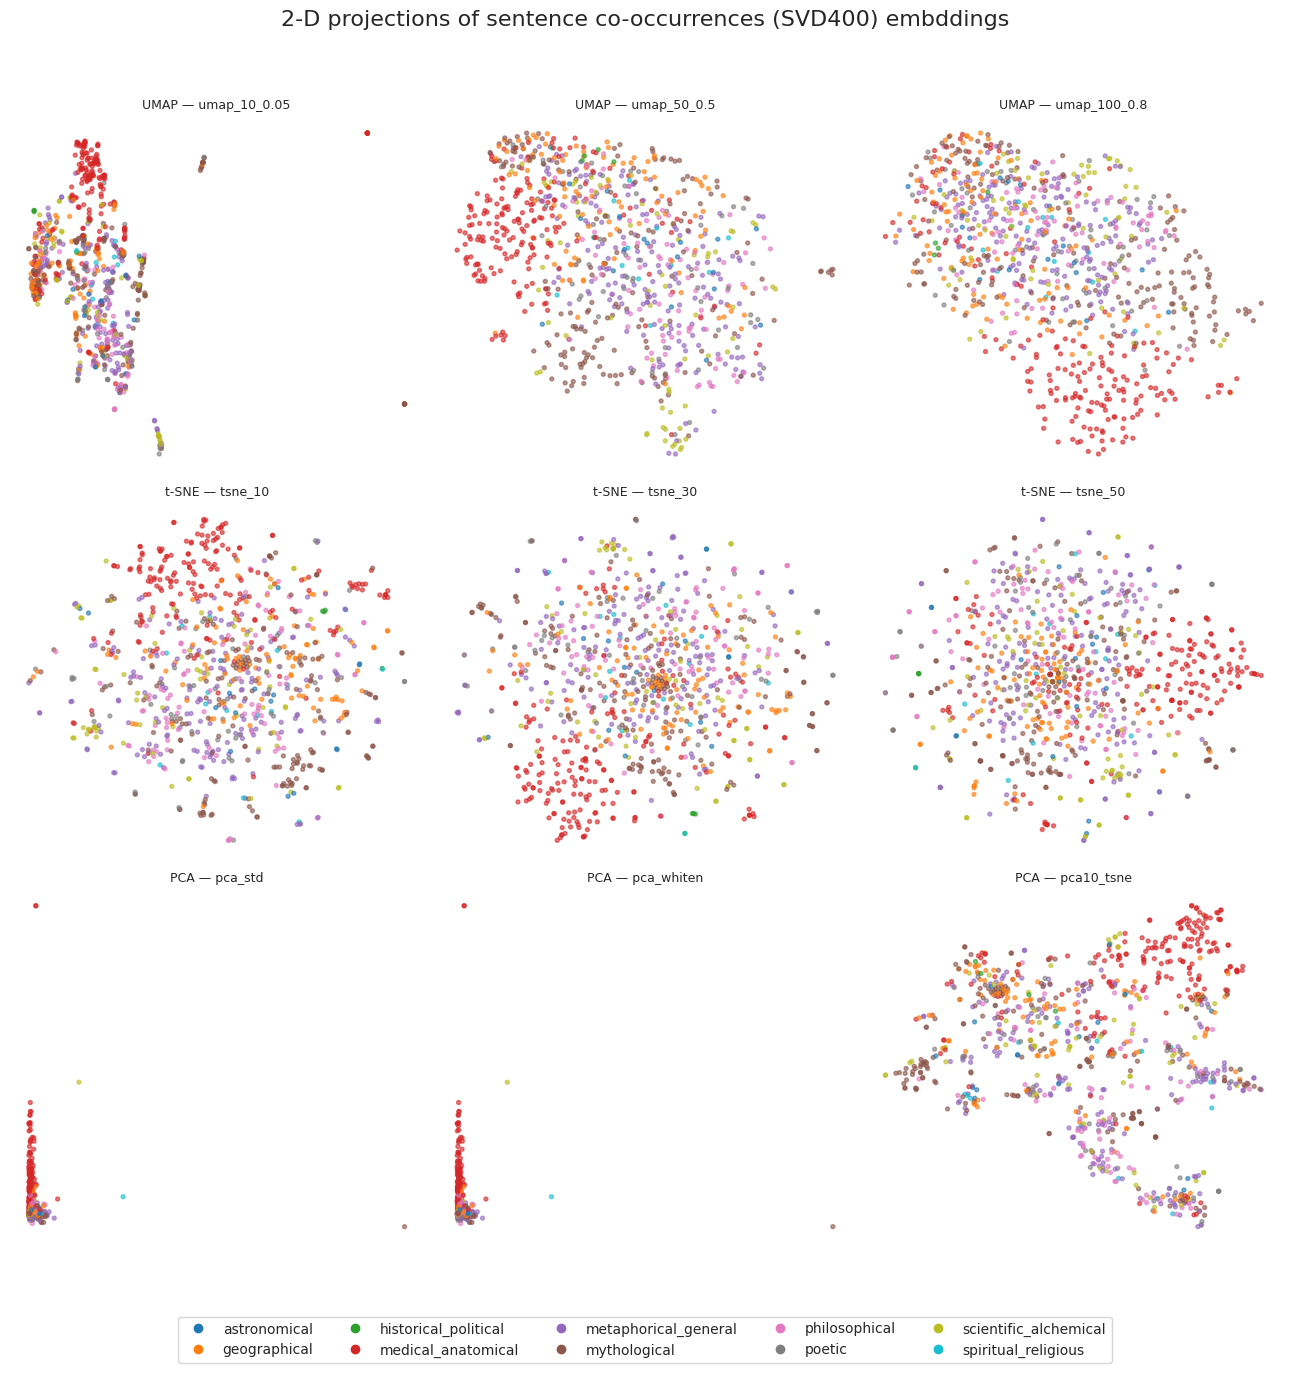

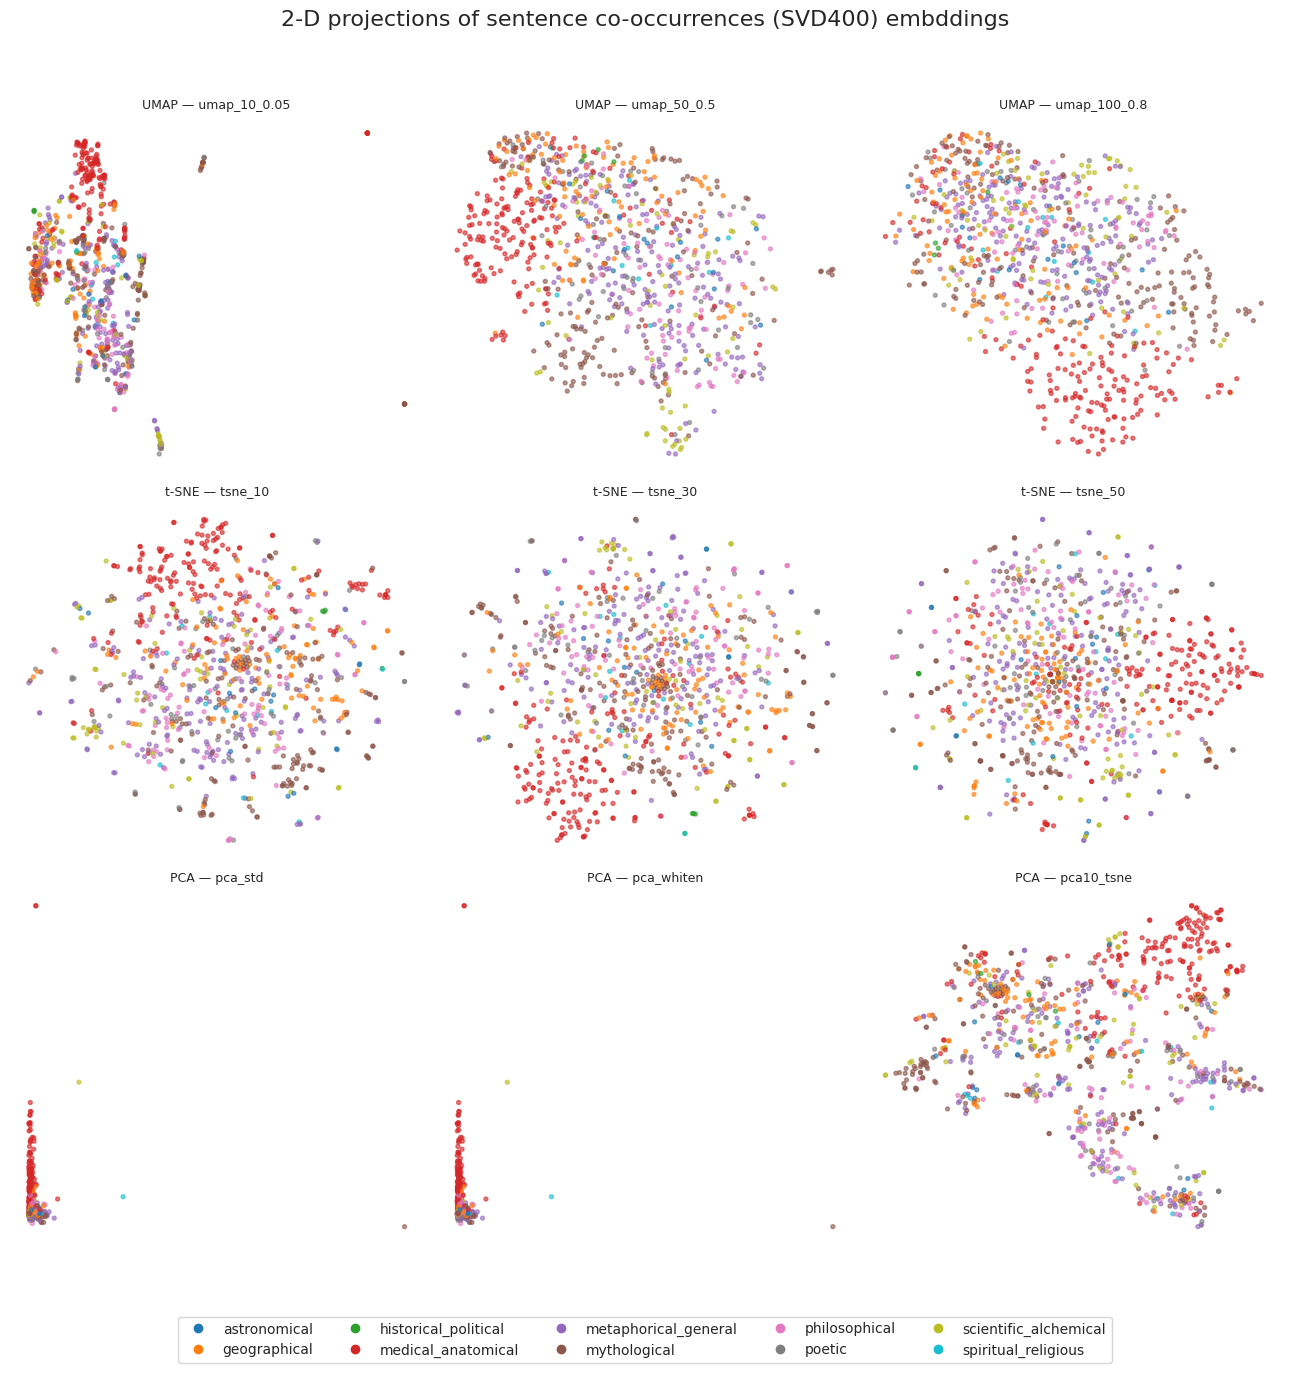

In [67]:
emb_array = np.stack(labyrinthus_df["svd400"].values)
plot_projections_for_embeddings(emb_array, "sentence co-occurrences (SVD400)")

In [73]:
labyrinthus_df.columns

Index(['author', 'title', 'grela_id', 'sentence_id', 'sentence_text',
       'context_3sents', 'tokens', 'concordance_tokens', 'not_before',
       'not_after', 'date_random', 'lagt_genre', 'lagt_provenience',
       'noscemus_genre', 'noscemus_discipline', 'target_token_id',
       'target_char_start', 'target_char_end', 'classification_single',
       'classification_single_label', 'xlmr_sentence', 'xlmr_sp_tokens',
       'xlmr_aug_tokens', 'embed_l5', 'att_l5', 'embed_l6', 'att_l6',
       'embed_l7', 'att_l7', 'embed_l8', 'att_l8', 'embed_l9', 'att_l9',
       'embed_l10', 'att_l10', 'embed_l11', 'att_l11', 'xlmr_conc_text',
       'xlmr_conc_sp_tokens', 'xlmr_conc_aug_tokens', 'embed_conc_l5',
       'att_conc_l5', 'embed_conc_l6', 'att_conc_l6', 'embed_conc_l7',
       'att_conc_l7', 'embed_conc_l8', 'att_conc_l8', 'embed_conc_l9',
       'att_conc_l9', 'embed_conc_l10', 'att_conc_l10', 'embed_conc_l11',
       'att_conc_l11', 'att_l5_raw_embed', 'att_l6_raw_embed',
       'att_

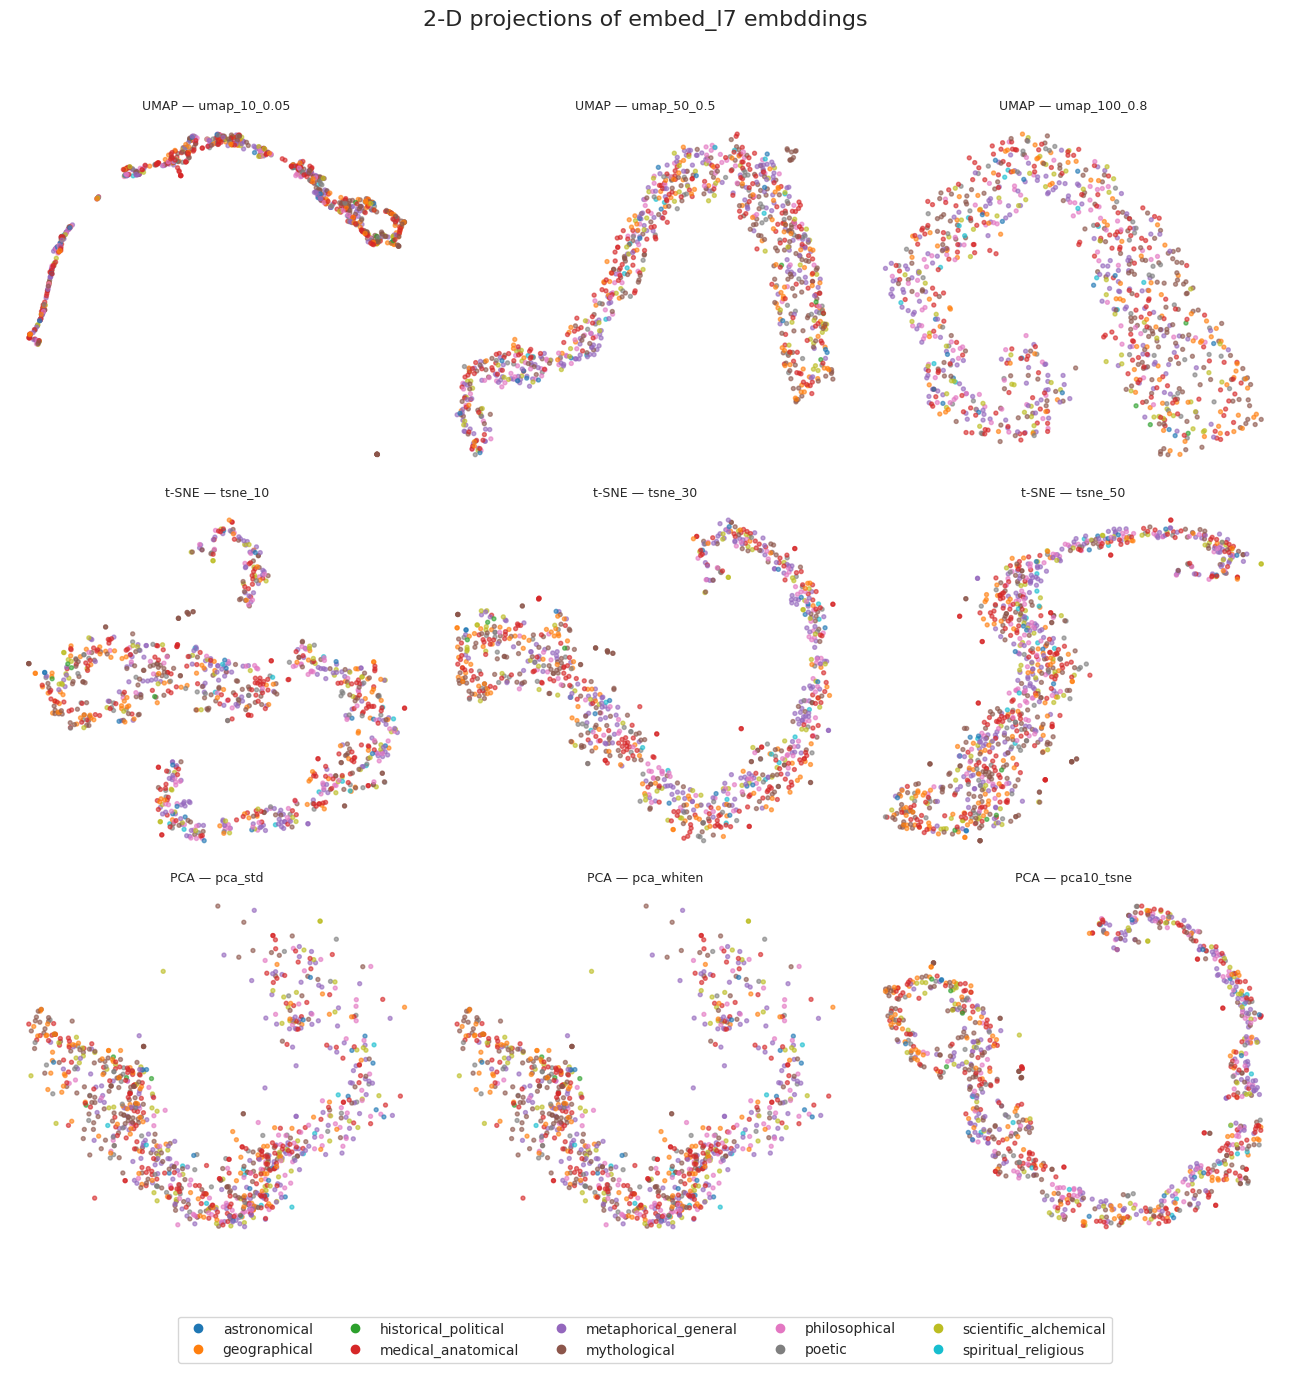

In [69]:
emb_array = np.stack(labyrinthus_df["embed_l7"].values)
fig = plot_projections_for_embeddings(emb_array, "embed_l7")

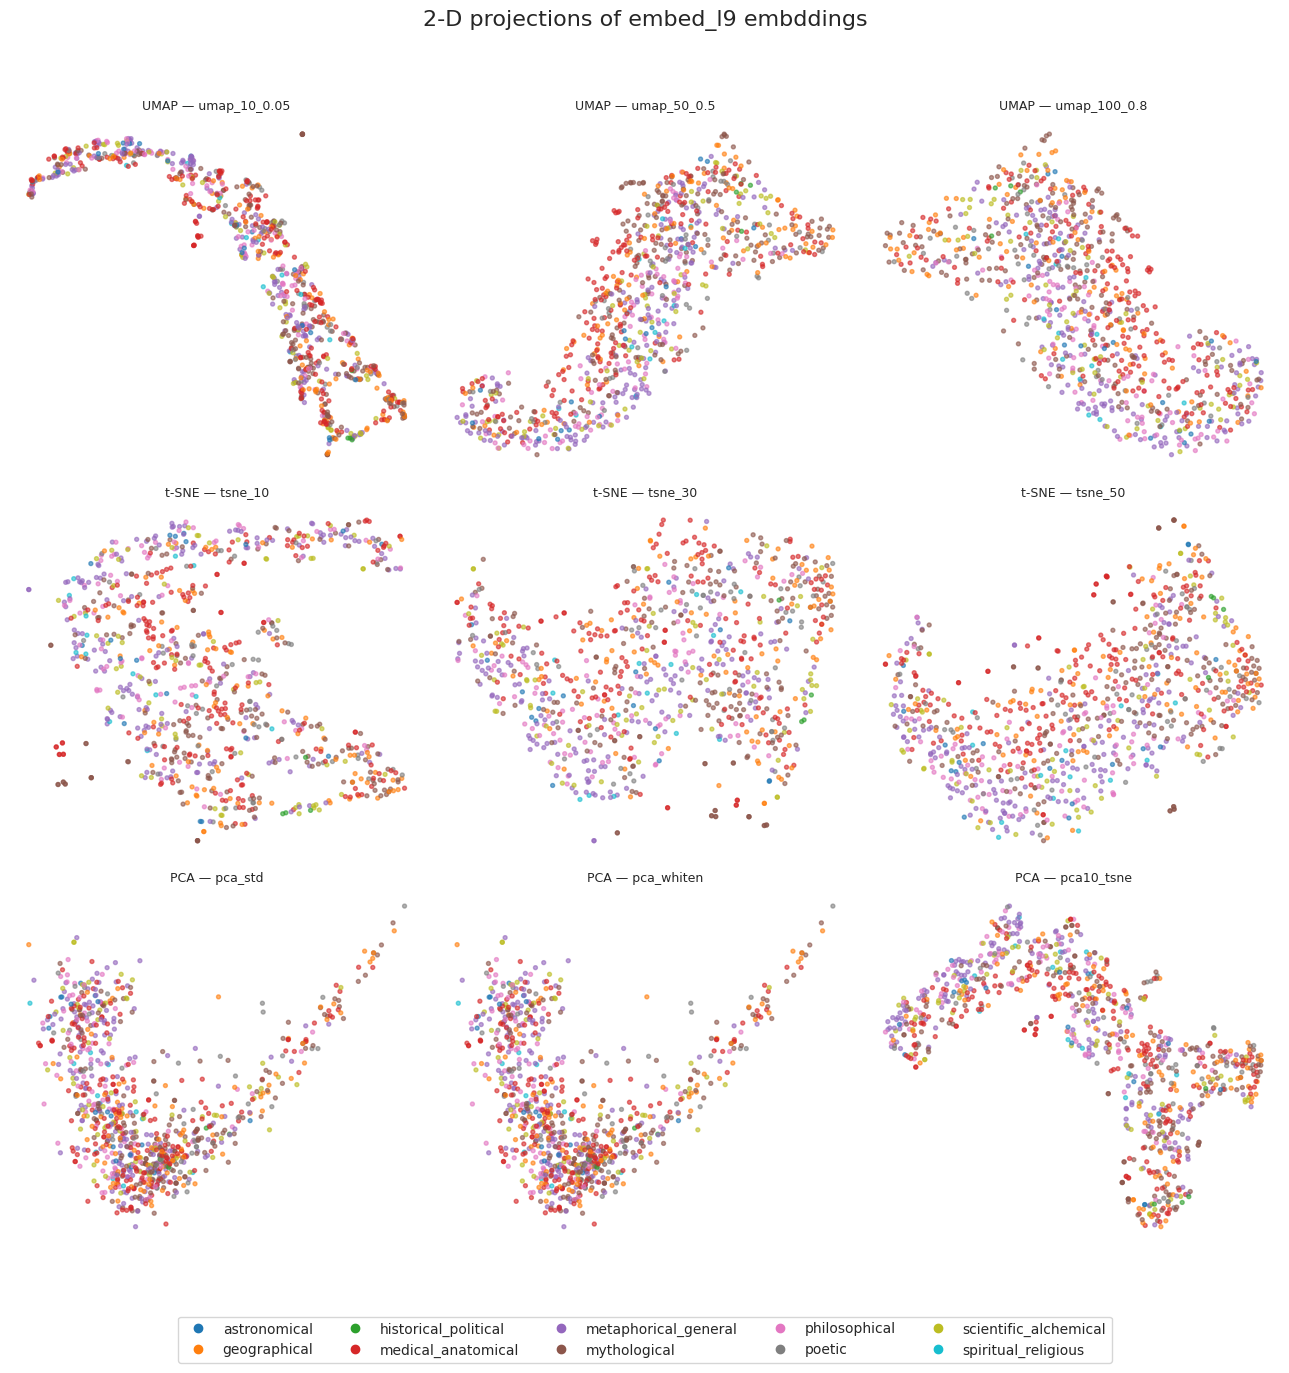

In [70]:
emb_array = np.stack(labyrinthus_df["embed_l9"].values)
fig = plot_projections_for_embeddings(emb_array, "embed_l9")

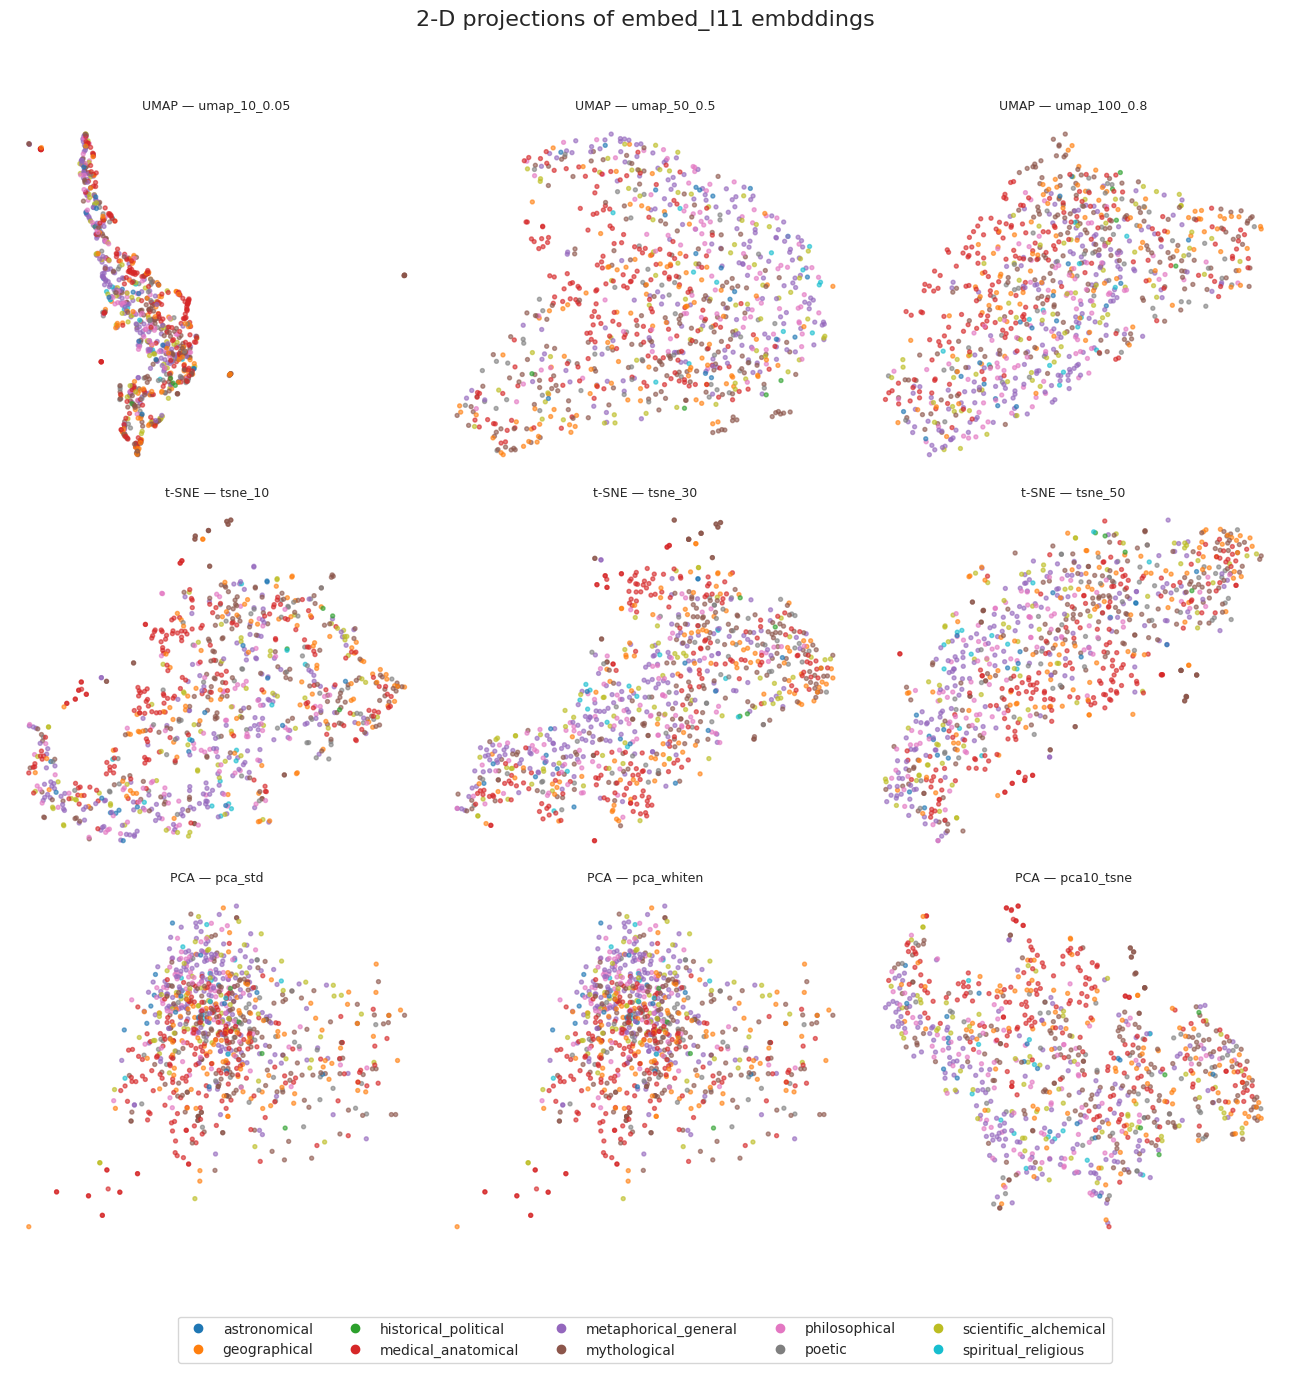

In [71]:
emb_array = np.stack(labyrinthus_df["embed_l11"].values)
fig = plot_projections_for_embeddings(emb_array, "embed_l11")

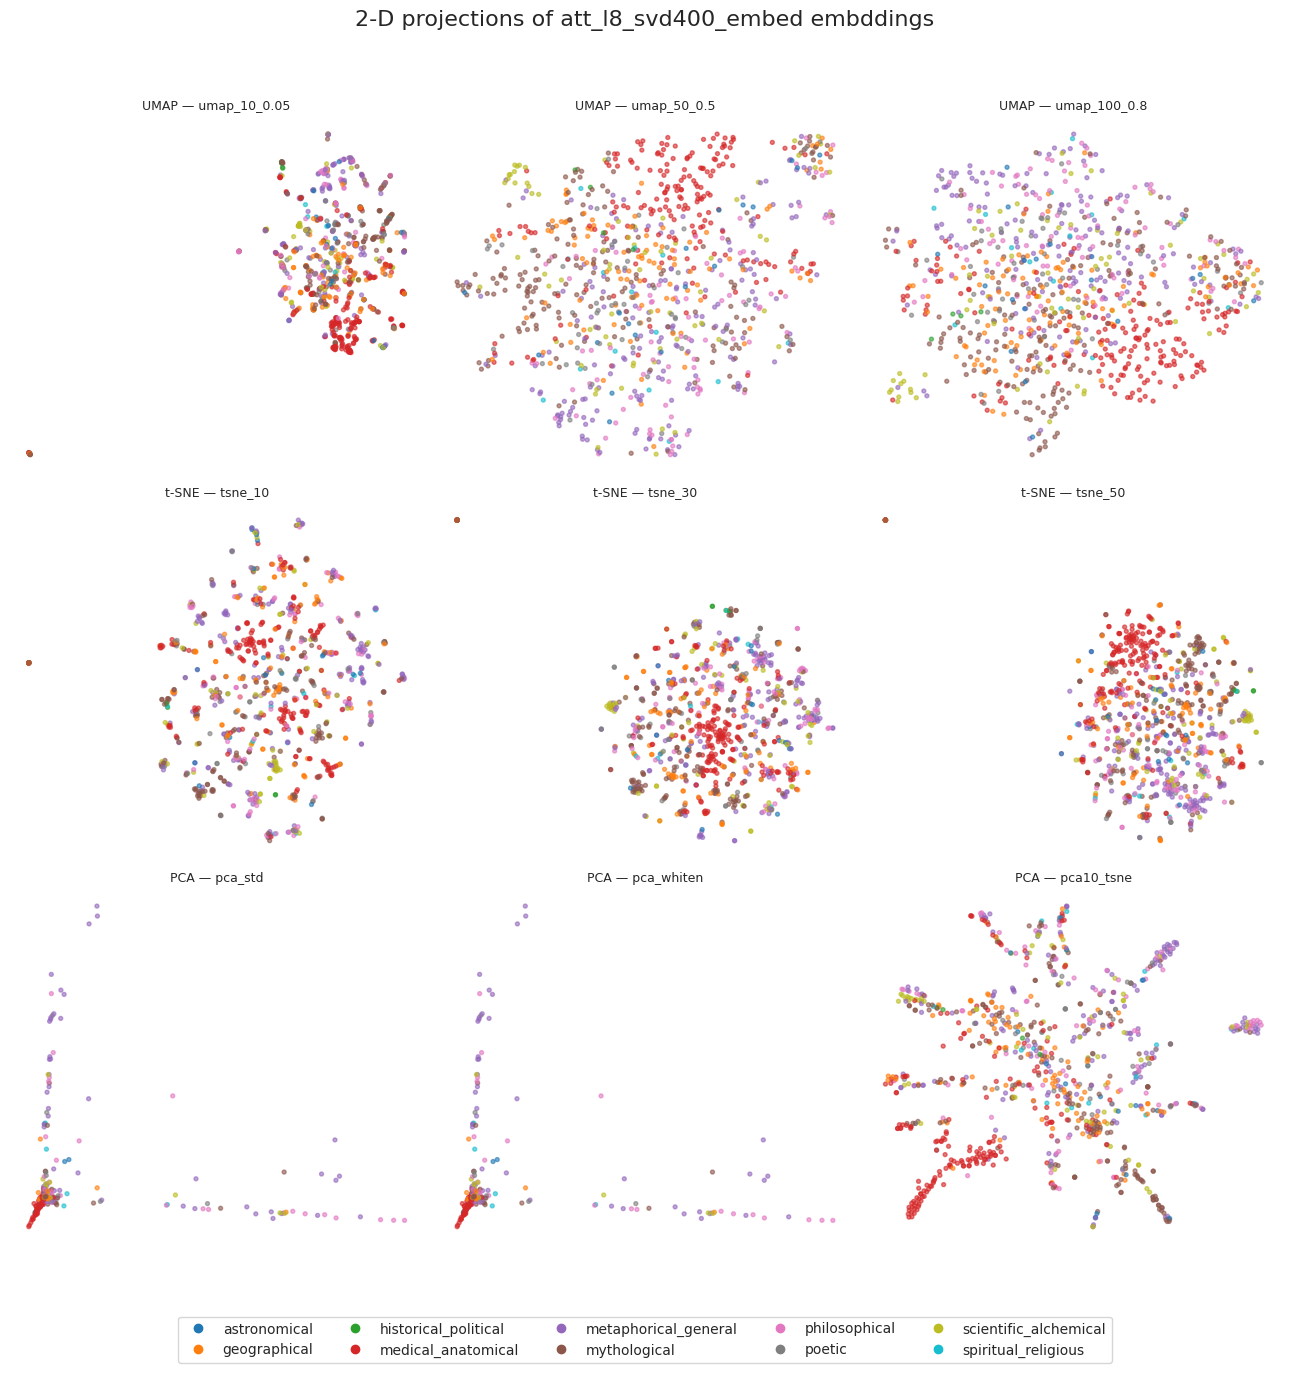

In [79]:
emb_array = np.stack(labyrinthus_df["att_l8_svd400_embed"].values)
fig = plot_projections_for_embeddings(emb_array, "att_l8_svd400_embed")

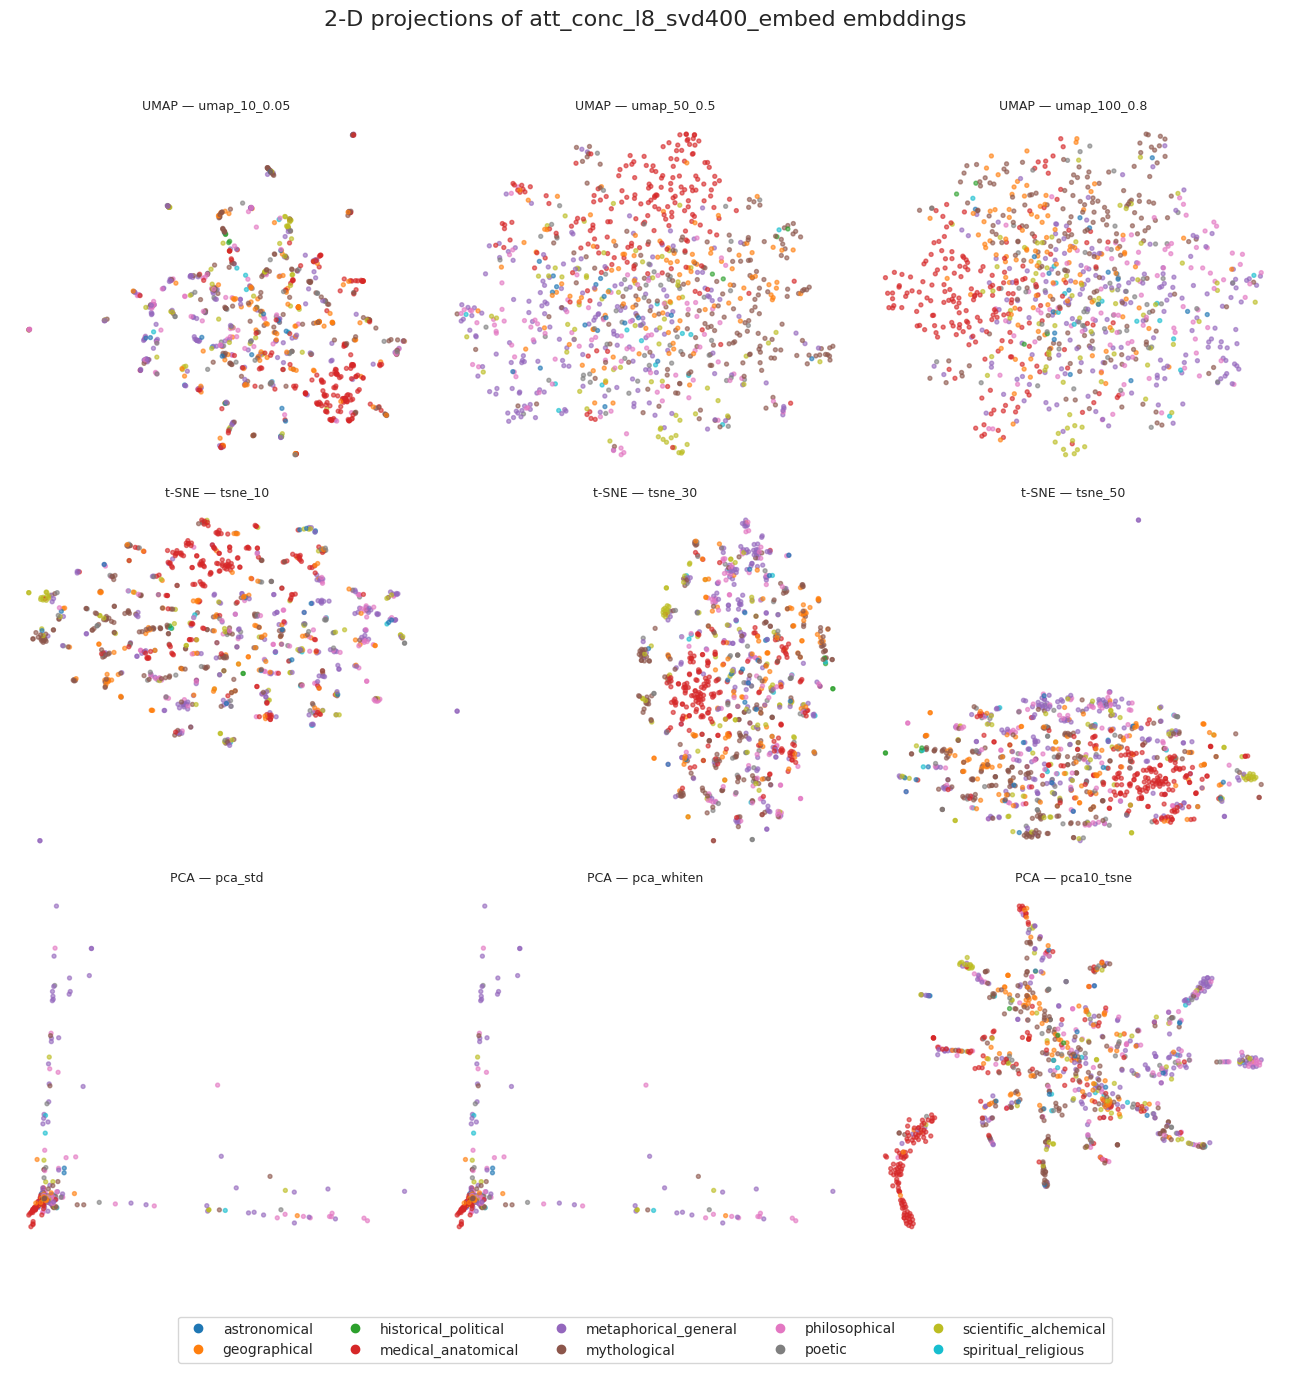

In [80]:
emb_array = np.stack(labyrinthus_df["att_conc_l8_svd400_embed"].values)
fig = plot_projections_for_embeddings(emb_array, "att_conc_l8_svd400_embed")

In [81]:
def concatenate_embeddings(df: pd.DataFrame, columns: list[str]) -> np.ndarray:
    """
    Concatenate and stack embeddings from the specified columns for each row.
    Each selected column must contain array-like (same-length) embeddings per row.

    Returns
    -------
    emb_array : np.ndarray
        Shape (num_rows, total_embedding_dim)
    """
    # Each result is a single flat vector for one row (concatenating all columns)
    concat_rows = [
        np.concatenate([df[col].iloc[i] for col in columns])
        for i in range(len(df))
    ]
    return np.stack(concat_rows)


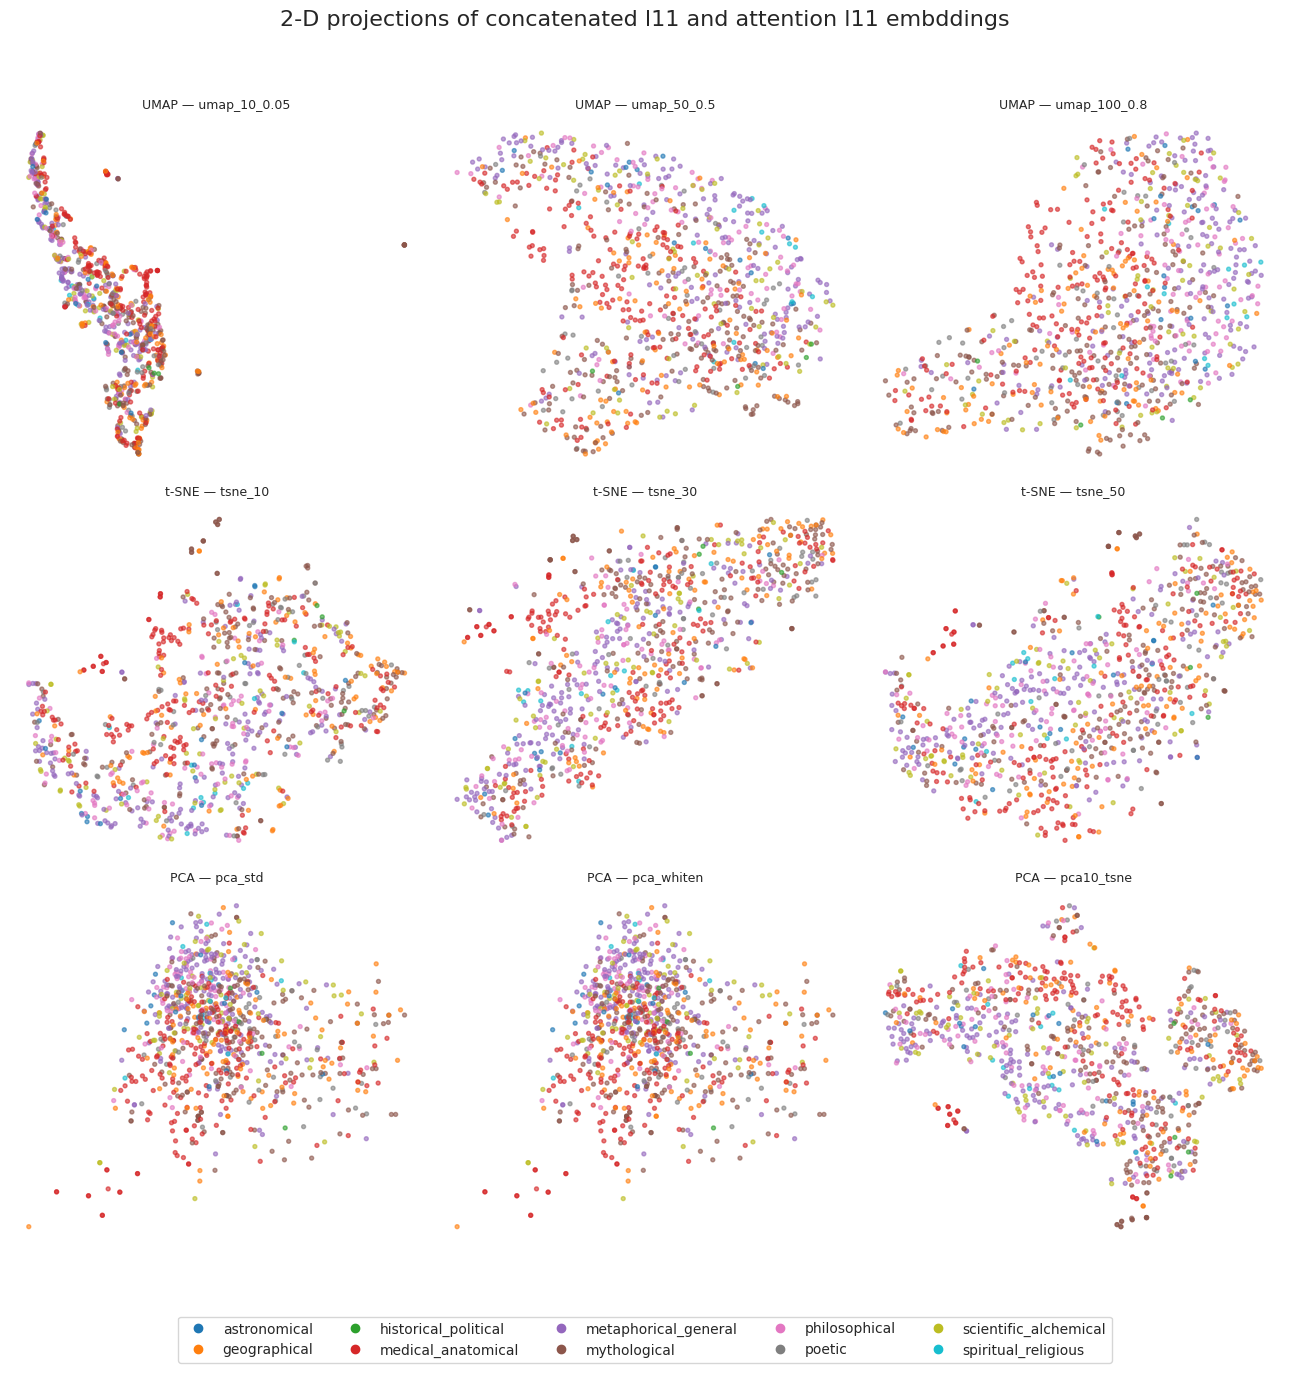

In [83]:
# Choose any embedding column you've built:
emb_array = concatenate_embeddings(labyrinthus_df, ["embed_l11", "att_l11_svd400_embed"])

fig = plot_projections_for_embeddings(emb_array, "concatenated l11 and attention l11")

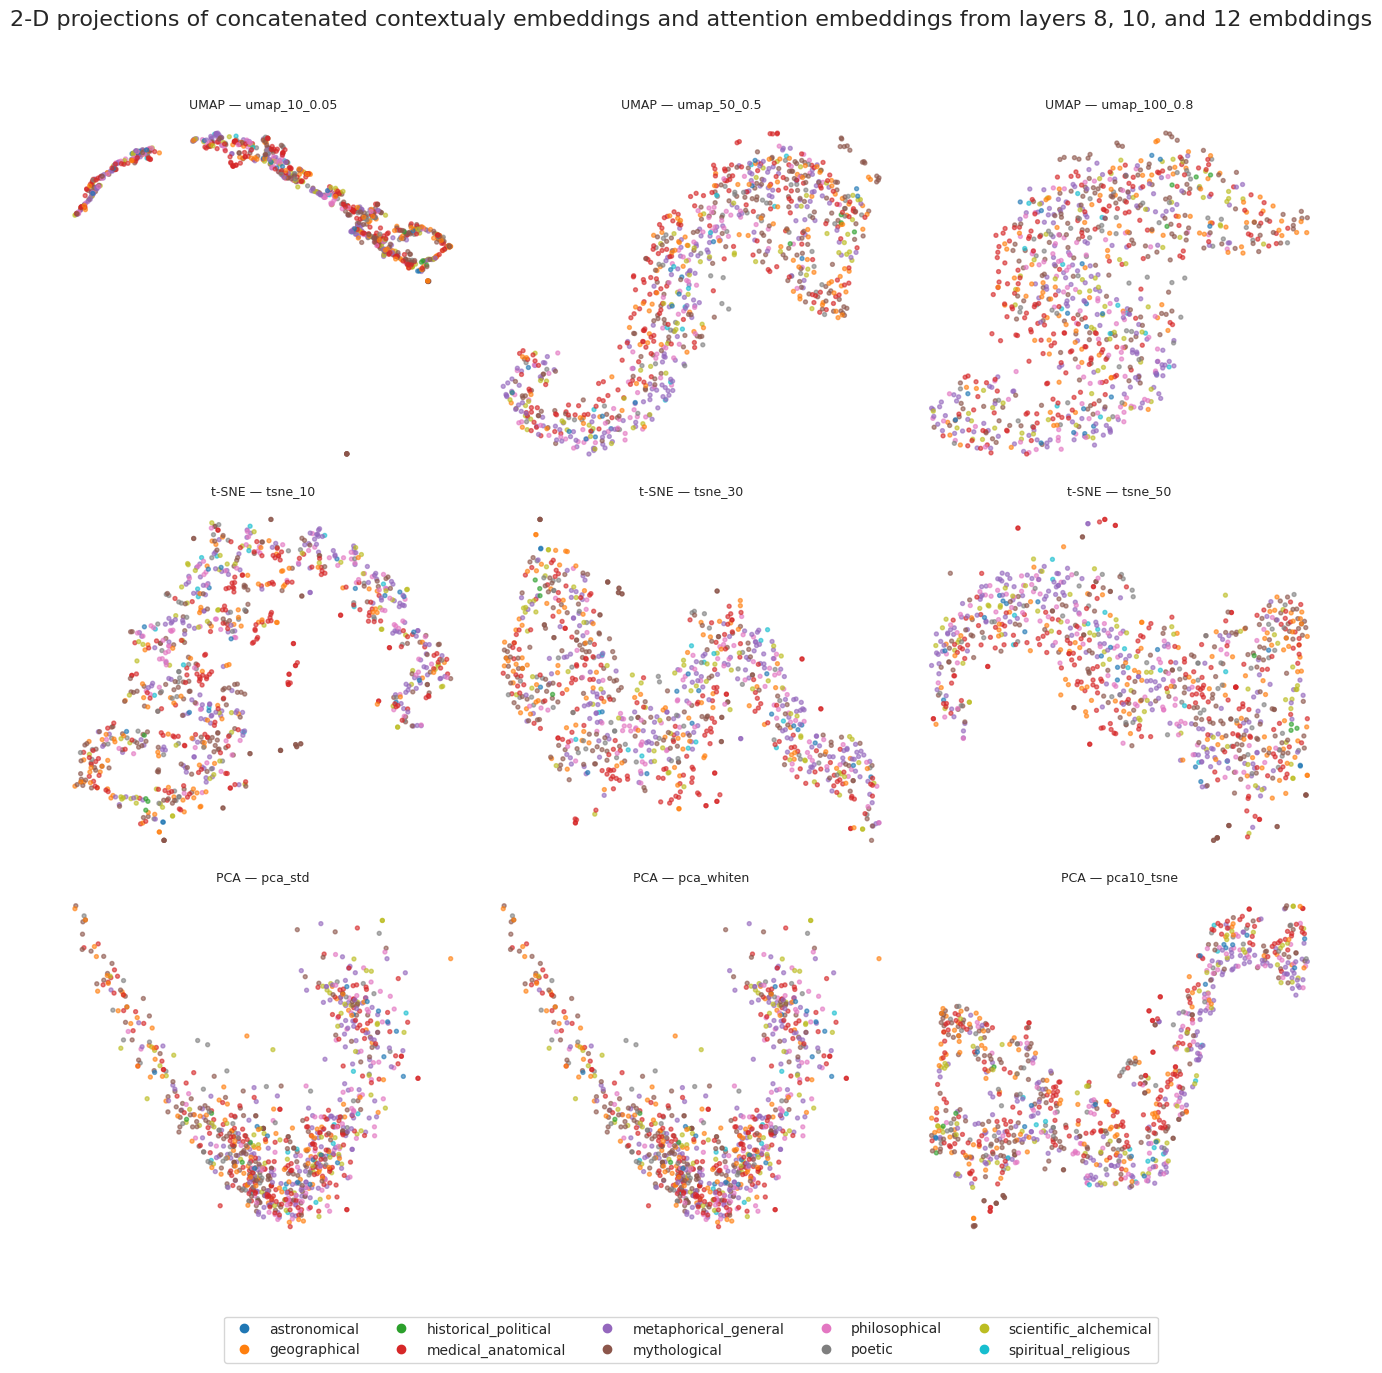

In [84]:
# Choose any embedding column you've built:
emb_array = concatenate_embeddings(labyrinthus_df, ["embed_l7", "embed_l9", "embed_l11", "att_l7_svd400_embed", "att_l9_svd400_embed", "att_l11_svd400_embed"])

fig = plot_projections_for_embeddings(emb_array, "concatenated contextualy embeddings and attention embeddings from layers 8, 10, and 12")

In [85]:
labyrinthus_df.to_parquet("../data/large_files/labyrinthus_embeddings.parquet")

## Supervised classification

In [44]:
# ------------------------------------------------------------------
# common objects
# ------------------------------------------------------------------
y  = labyrinthus_df["label20"].values           # 21 classes incl. “other”
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

pipe = make_pipeline(
    StandardScaler(with_mean=False),
    LogisticRegression(max_iter=4000,
                       multi_class="multinomial",
                       solver="lbfgs",
                       n_jobs=-1)
)

# ------------------------------------------------------------------
# loop over layers 8–11
# ------------------------------------------------------------------
results = []

for L in range(6, 12):
    X_emb = np.stack(labyrinthus_df[f"embed_l{L}"].values)                 # (N,768)
    X_att = np.stack(labyrinthus_df[f"att_l{L}_svd400_embed"].values)      # (N,400)

    f1_emb = cross_val_score(pipe, X_emb, y, cv=cv, scoring="f1_macro").mean()
    f1_att = cross_val_score(pipe, X_att, y, cv=cv, scoring="f1_macro").mean()

    results.append((L, f1_emb, f1_att))
    print(f"Layer {L}:  Embed-only F1 = {f1_emb:.4f}   |   Att-only F1 = {f1_att:.4f}")

# ------------------------------------------------------------------
# (optional) nice DataFrame of the summary
# ------------------------------------------------------------------
layer_perf = pd.DataFrame(results,
                          columns=["Layer", "Embed_F1", "Att_SVD400_F1"])
display(layer_perf)

Layer 6:  Embed-only F1 = 0.3825   |   Att-only F1 = 0.3816
Layer 7:  Embed-only F1 = 0.3870   |   Att-only F1 = 0.3616
Layer 8:  Embed-only F1 = 0.3897   |   Att-only F1 = 0.3312
Layer 9:  Embed-only F1 = 0.3949   |   Att-only F1 = 0.3900
Layer 10:  Embed-only F1 = 0.3785   |   Att-only F1 = 0.3925
Layer 11:  Embed-only F1 = 0.3936   |   Att-only F1 = 0.3920


Layer  Embed_F1  Att_SVD400_F1
0      6  0.382507       0.381552
1      7  0.387049       0.361561
2      8  0.389703       0.331158
3      9  0.394855       0.390050
4     10  0.378511       0.392453
5     11  0.393585       0.391955

In [48]:
X_emb = np.stack(labyrinthus_df["svd400"].values)                 #
f1_emb = cross_val_score(pipe, X_emb, y, cv=cv, scoring="f1_macro").mean()
f1_emb

0.36213038484609095

In [46]:
# --------------------------------------------------------------------
# 0.  Collect feature matrices once, keep in RAM  (~ few-100 MB total)
# --------------------------------------------------------------------
embed_mat   = {L: np.stack(labyrinthus_df[f"embed_l{L}"].values)
               for L in range(6, 12)}
att_mat     = {L: np.stack(labyrinthus_df[f"att_l{L}_svd400_embed"].values)
               for L in range(6, 12)}

y = labyrinthus_df["label20"].values          # 21 classes (top-20 + other)

# --------------------------------------------------------------------
# 1.  Cross-validation set-up
# --------------------------------------------------------------------
from sklearn.linear_model    import LogisticRegression
from sklearn.pipeline        import make_pipeline
from sklearn.preprocessing   import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score

pipe = make_pipeline(StandardScaler(with_mean=False),
                     LogisticRegression(max_iter=4000,
                                        multi_class="multinomial",
                                        solver="lbfgs",
                                        n_jobs=-1))
cv = StratifiedKFold(5, shuffle=True, random_state=42)

# --------------------------------------------------------------------
# 2.  Evaluate every Emb-layer × Att-layer pair
# --------------------------------------------------------------------
records = []
for L_emb in range(6, 11+1):
    for L_att in range(6, 11+1):
        X_pair = np.hstack([embed_mat[L_emb], att_mat[L_att]])   # concat (768 + 400)
        score  = cross_val_score(pipe, X_pair, y,
                                 cv=cv, scoring="f1_macro").mean()
        records.append({"Embed_L": L_emb,
                        "Att_L":   L_att,
                        "F1_macro": score})

pair_df = (pd.DataFrame(records)
             .pivot(index="Embed_L", columns="Att_L", values="F1_macro")
             .round(3))

pair_df

Att_L       6      7      8      9      10     11
Embed_L                                          
6        0.424  0.431  0.406  0.431  0.445  0.448
7        0.444  0.447  0.421  0.441  0.462  0.457
8        0.409  0.433  0.416  0.438  0.441  0.440
9        0.416  0.436  0.411  0.427  0.454  0.443
10       0.433  0.463  0.404  0.457  0.452  0.460
11       0.465  0.464  0.426  0.450  0.463  0.465

## backupm

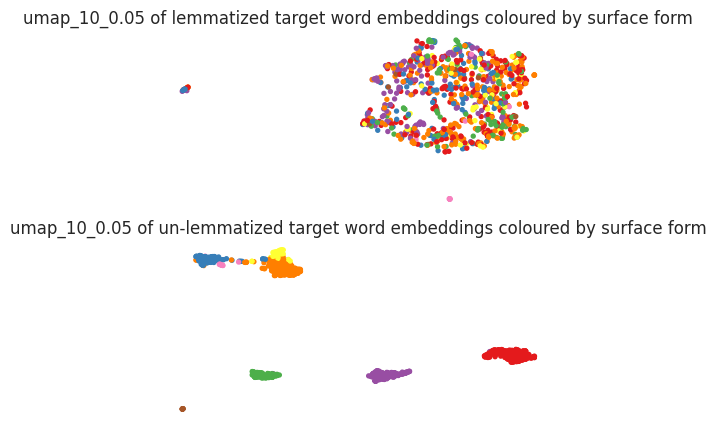

In [170]:
surface = labyrinthus_df["concordance_tokens"].apply(
    lambda toks: next(t for t in toks if t["lemma"].lower() == "labyrinthus")["token_text"].lower()
)

palette = {f: c for f, c in zip(surface.unique(), plt.cm.Set1.colors)}


fig, [ax1, ax2] = plt.subplots(2,1, figsize=(5, 5))

emb_array = np.stack(labyrinthus_df["embed_hybrid_allpos"].values)
proj_series = compute_projections(emb_array)

proj_key = "umap_10_0.05"
xs = proj_series.str[proj_key].str["x"]
ys = proj_series.str[proj_key].str["y"]

ax1.scatter(xs, ys, c=surface.map(palette), s=8)
ax1.set_title(f"{proj_key} of lemmatized target word embeddings coloured by surface form")
ax1.axis("off")

emb_array = np.stack(labyrinthus_df["embed_surface_allpos"].values)
proj_series = compute_projections(emb_array)

proj_key = "umap_10_0.05"

xs = proj_series.str[proj_key].str["x"]
ys = proj_series.str[proj_key].str["y"]
ax2.scatter(xs, ys, c=surface.map(palette), s=8)
ax2.set_title(f"{proj_key} of un-lemmatized target word embeddings coloured by surface form")
ax2.axis("off")

plt.show()

In [85]:
labyrinthus_df.head(5)

author                                 title  \
0  Humbertus Silvae Candidae1010-1061                    Adversus Simoniacos   
1                      Petrus Damianus           Patrologia Latina, vol. 145   
2               Rodulphus S. Trudonis                      Vita S. Lietberti   
3                    Domnizo Canusinus             Vita et carmina Mathildis   
4               Durandus Trobarnensis   Liber de corpore et sanguine Christi   

   grela_id    sentence_id                                      sentence_text  \
0  cc_10012  cc_10012_2812  Exploret qui potest qualiter, et qua hunc laby...   
1  cc_10077    cc_10077_50  Et poenae factus est auctor, qui poenalis laby...   
2  cc_10161    cc_10161_32  mirantibus magistris penetrat labyrinthos Scri...   
3  cc_10261   cc_10261_892  Ista fuit, quae par habuit regemque Deumque, H...   
4  cc_10298   cc_10298_920  Uerum quia quidam peruersi ex hac tanti doctor...   

                                      context_3sents  \
0  Si enim, ut philosophus allegat, qui non prohi...   
1  Protinus igitur projectus in taurum, quod infe...   
2  Ducitur sitibundo pectore currens ad fontem ph...   
3  Ista fuit, quae diripuit Paulumque Petrumque; ...   
4  Xxui. | Uerum quia quidam peruersi ex hac tant...   

                                              tokens  \
0  [{'char_end': 8, 'char_start': 0, 'lemma': 'ex...   
1  [{'char_end': 2, 'char_start': 0, 'lemma': 'et...   
2  [{'char_end': 10, 'char_start': 0, 'lemma': 'm...   
3  [{'char_end': 4, 'char_start': 0, 'lemma': 'is...   
4  [{'char_end': 5, 'char_start': 0, 'lemma': 'ue...   

                                  concordance_tokens  \
0  [{'char_end': 303, 'char_start': 299, 'lemma':...   
1  [{'char_end': 83, 'char_start': 75, 'lemma': '...   
2  [{'char_end': 144, 'char_start': 136, 'lemma':...   
3  [{'char_end': 43, 'char_start': 40, 'lemma': '...   
4  [{'char_end': 10, 'char_start': 6, 'lemma': 'q...   

                classification  not_before  ...  \
0                 metaphorical      1010.0  ...   
1         poetic, metaphorical      1007.0  ...   
2  metaphorical, philosophical         NaN  ...   
3         metaphorical, poetic      1130.0  ...   
4                 metaphorical         NaN  ...   

                                            embed_l8  \
0  [-0.5996939, -0.08402276, 0.24582314, 0.246073...   
1  [-0.55678105, -0.031190008, 0.18337364, 0.4370...   
2  [-0.070512734, -0.010591162, -0.093808964, 0.2...   
3  [-0.20573536, 0.0940672, 0.14274016, 0.2886553...   
4  [-0.41097933, 0.07569985, 0.18987988, 0.161353...   

                                              att_l8  \
0  {'exploro': {'weight': 0.007501654326915741, '...   
1  {'et': {'weight': 0.003848183201625943, 'piece...   
2  {'miro': {'weight': 0.03680548816919327, 'piec...   
3  {'iste': {'weight': 0.001744522713124752, 'pie...   
4  {'uerus': {'weight': 0.005245175678282976, 'pi...   

                                            embed_l9  \
0  [-0.4901215, -0.014518358, 0.11257135, -0.0287...   
1  [-0.4923613, -0.1829148, 0.15112661, 0.3343788...   
2  [-0.10879725, 0.09882534, -0.008079263, 0.1313...   
3  [-0.23654726, 0.043308813, 0.059855238, 0.2533...   
4  [-0.40861088, -0.1697307, 0.14324735, 0.064479...   

                                              att_l9  \
0  {'exploro': {'weight': 0.0040437448769807816, ...   
1  {'et': {'weight': 0.006557437125593424, 'piece...   
2  {'miro': {'weight': 0.01636236347258091, 'piec...   
3  {'iste': {'weight': 0.0017882290994748473, 'pi...   
4  {'uerus': {'weight': 0.01136833056807518, 'pie...   

                                           embed_l10  \
0  [-0.22389103, -0.08037936, 0.4684307, -0.07405...   
1  [-0.3993842, -0.17896965, 0.33668458, 0.163039...   
2  [-0.23412725, 0.0044030286, 0.25399756, 0.1273...   
3  [-0.23956929, -0.014918415, 0.138808, 0.211936...   
4  [-0.35462877, -0.19699067, 0.22254297, 0.14897...   

                                             att_l10  \
0  {'

In [ ]:
surface = labyrinthus_df'["concordance_tokens"].apply(
    lambda toks: next(t for t in toks if t["lemma"].lower() == "labyrinthus")["token_text"].lower()
)

palette = {f: c for f, c in zip(surface.unique(), plt.cm.Set1.colors)}


fig, [ax1, ax2] = plt.subplots(2,1, figsize=(5, 5))

emb_array = np.stack(labyrinthus_df["embed_hybrid_allpos"].values)
proj_series = compute_projections(emb_array)

proj_key = "umap_10_0.05"
xs = proj_series.str[proj_key].str["x"]
ys = proj_series.str[proj_key].str["y"]

ax1.scatter(xs, ys, c=surface.map(palette), s=8)
ax1.set_title(f"{proj_key} of lemmatized target word embeddings coloured by surface form")
ax1.axis("off")

emb_array = np.stack(labyrinthus_df["embed_surface_allpos"].values)
proj_series = compute_projections(emb_array)

proj_key = "umap_10_0.05"

xs = proj_series.str[proj_key].str["x"]
ys = proj_series.str[proj_key].str["y"]
ax2.scatter(xs, ys, c=surface.map(palette), s=8)
ax2.set_title(f"{proj_key} of un-lemmatized target word embeddings coloured by surface form")
ax2.axis("off")

plt.show()